# TP3 - Market Basket Analysis
INF8111 - Fouille de données, Eté 2024



In [1]:
ROOT = 'gs://exemple_a2024/notebooks/jupyter/data/'

## 1. Introduction: Market Basket Analysis

### Présentation

Le *Market Basket Analysis* (MBA) est une technique d'analyse de la fouille de données qui permet de découvrir les associations entre les produits ou leur regroupement. En explorant des motifs intéressants à partir d'une vaste collection de données, le MBA vise à comprendre / révéler les comportements d'achat des clients en se basant sur la théorie selon laquelle si vous avez acheté un certain ensemble de produits, vous êtes plus (ou moins) susceptible d'acheter un autre groupe de produits. En d'autres termes, le MBA permet aux détaillants d'identifier la relation entre les articles que les clients achètent, révélant des tendances d'articles souvent achetés ensemble.

Une approche largement utilisée pour explorer ces motifs consiste à construire *** des règles d'association *** telles que
- **si** acheté *ITEM_1* **alors** achètera *ITEM_2* avec **confiance** *X*.

Ces associations n'ont pas à être des règles individuelles. Ils peuvent impliquer de nombreux éléments. Par exemple, une personne dans un supermarché peut ajouter des œufs dans son panier, puis le MBA peut suggérer qu'elle achètera également du pain et/ou de la farine:

+ **si**  acheté *OEUFS* **alors** achètera [*PAIN* avec confiance *0,2*; *FARINE* avec confiance 0,05].

Cependant, si la personne décide maintenant d'ajouter de la farine à son panier, la nouvelle règle d'association pourrait être comme ci-dessous, suggérant des ingrédients pour faire un gâteau.

+ **si** acheté [*OEUFS, FARINE*] **alors** achètera [*SUCRE* avec confiance 0,45; LEVURE avec confiance 0,12; *PAIN* avec confiance *0,03*].

Il existe de nombreux scénarios réels où le MBA joue un rôle central dans l'analyse des données, comme les transactions de supermarché, les commandes en ligne ou l'historique des cartes de crédit. Avec une approche un peu moins mercantile, cet algorithme est aussi utilisé dans le domaine médical. Les spécialistes du marketing peuvent utiliser ces règles d'association pour organiser les produits corrélés plus près les uns des autres sur les étagères des magasins ou faire des suggestions en ligne afin que les clients achètent plus d'articles. Un MBA peut généralement aider les détaillants à répondre aux questions les suivantes:

- Quels articles sont souvent achetés ensemble ?
- Étant donné un panier, quels articles suggérer ?
- Comment placer les articles ensemble sur les étagères ?


### Objectif

Votre objectif dans ce TP est de développer un algorithme MBA pour révéler les motifs en créant des règles d'association dans un ensemble de données volumineux avec plus de trois millions de transactions de supermarché. Cependant, la collecte de règles d'association dans les grands ensembles de données est un problème très intensif en calcul, ce qui rend presque impossible leur exécution sans système distribué. Par conséquent, pour exécuter votre algorithme, vous aurez accès à un cluster de *cloud computing* distribué avec des centaines de cœurs.

À cette fin, un algorithme **MapReduce** sera implémenté avec le framework [Apache Spark](http://spark.apache.org), un système informatique distribué rapide. En résumé, Spark est un framework open source conçu avec une méthodologie *scale-out* qui en fait un outil très puissant pour les programmeurs ou les développeurs d'applications pour effectuer un volume massif de calculs et de traitement de données dans des environnements distribués. Spark fournit des API de haut niveau qui facilitent la création d'applications parallèles sans avoir à se soucier de la façon dont votre code et vos données sont parallélisés / distribués par le cluster informatique. Spark fait tout pour vous.

La mise en œuvre suivra l'algorithme d'analyse du panier de marché présenté par Jongwook Woo et Yuhang Xu (2012). L'image **workflow.pdf** illustre le flux de travail de l'algorithme et doit être utilisée pour consultation tout au long de ce TP. Les cases bleues sont celles où vous devez implémenter une méthode pour effectuer une fonction de mappage ou de réduction, et les cases grises représentent leur sortie attendue. **Toutes ces opérations sont expliquées en détail dans les sections suivantes.**

## 1. Configuration de Spark

#### Exécution avec le notebook Google Colab (fortement conseillé)

In [2]:
import os
!apt-get install openjdk-17-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
!pip install pyspark

#### Exécution en local



Spark fonctionne sur les systèmes Windows et UNIX (par exemple, Linux, Mac OS). Il est facile d'exécuter Spark localement sur une seule machine - tout ce dont vous avez besoin est d'avoir Java installé sur votre système PATH, ou la variable d'environnement JAVA_HOME pointant vers une installation Java. Il est obligatoire que le **JDK v8** soit installé sur votre système, car Spark ne prend actuellement en charge que cette version. Si ce n'est pas le cas, accédez à [la page Web de Java](https://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) pour télécharger et installer une machine virtuelle Java. N'oubliez pas de définir la variable d'environnement JAVA_HOME pour utiliser JDK v8 si votre installation ne le fait pas automatiquement.

L'interface entre Python et Spark se fait via **PySpark**, qui peut être installé en exécutant `pip install pyspark` ou configuré en suivant la séquence ci-dessous:

1. D'abord, allez sur http://spark.apache.org/downloads
2. Sélectionnez la dernière version de Spark et le package pré-construit pour Apache Hadoop 2.7
3. Cliquez pour télécharger **spark-2.4.5-bin-hadoop2.7.tgz** et décompressez-le dans le dossier de votre choix.
4. Ensuite, exportez les variables suivantes pour lier PYSPARK (l'interface python de Spark) à votre distribution python dans votre fichier `~/.bash_profile`.

``
export SPARK_HOME=/chemin/ vers / spark-2.4.5-bin-hadoop2.7
export PYTHONPATH="$SPARK_HOME/python:$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$SPARK_HOME/python/lib/pyspark.zip:$ PYTHONPATH"
export PYSPARK_PYTHON=/chemin/vers/votre/python3
``

5. Exécutez `source ~./bash_profile` pour effectuer les modifications et redémarrer cette session de notebook jupyter.

#### Test de l'installation
À l'aide du code suivant, vous pouvez tester si Spark est correctement installé.

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



### 1.1 Exemple de comptage de produits / Products Counting Example

Pour tester votre installation et commencer à vous familiariser avec Spark, nous suivrons un exemple qui compte combien de fois les produits du GroceryDataset dataset ont été achetés.

Le principal point d'entrée pour commencer la programmation avec Spark est [l'API RDD](https://spark.apache.org/docs/latest/rdd-programming-guide.html), une excellente abstraction Spark pour travailler avec MapReduce. RDD est une collection d'éléments partitionnés sur les nœuds du cluster qui peuvent fonctionner en parallèle. En d'autres termes, RDD est la façon dont Spark maintient vos données prêtes à exécuter une fonction (par exemple, une fonction Map ou une fonction reduce) en parallèle. **Ne vous inquiétez pas si cela semble toujours déroutant, il sera clair une fois que vous commencerez à l'implémenter**. Cependant, cela fait partie de ce TP d'étudier / consulter [Spark python API](https://spark.apache.org/docs/latest/api/python/) et d'apprendre à l'utiliser. Certaines fonctions utiles offertes par l'API RDD sont:

1. **map**: return a new RDD by applying a function to each element of this RDD.
2. **flatMap**: return a new RDD by first applying a function to all elements of this RDD, and then flattening the results. **Should be used when each entry will yield more than one mapped element**
3. **reduce**: reduces the elements of this RDD using the specified commutative and associative binary operator.
4. **reduceByKey**: merge the values for each key using an associative and commutative reduce function
5. **groupByKey**: group the values for each key in the RDD into a single sequence
6. **collect**: return a list that contains all of the elements in this RDD. **Should not be used when working with a lot of data**
7. **takeSample**: return a sampled subset of this RDD
8. **count**: return the number of elements in this RDD.
9. **filter**: return a new RDD containing only the elements that satisfy a predicate.

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id

def map_to_product(row):
    """
    Map each transaction into a set of KEY-VALUE elements.
    The KEY is the word (product) itself and the VALUE is its number of apparitions.
    """
    products = row.transaction.split(',') # split products from the column transaction
    for p in products:
        yield (p, 1)

def reduce_product_by_key(value1, value2):
    "Reduce the mapped objects to unique words by merging (summing ) their values"
    return value1+value2

# Initializates a object of SparkSession class, main entry point to Spark's funcionalites
spark = SparkSession.builder.getOrCreate()

# Read a grocery dataset
grocery = spark.read.csv(ROOT + "GroceryDataset.csv") \
              .withColumnRenamed('_c0', 'transaction') \
              .select("*").withColumn("order_id", monotonically_increasing_id())

grocery = grocery.select("order_id", "transaction")

print("Grocery dataset")
grocery.show()

# Obtain a RDD object to call a map function
grocery_rdd = grocery.rdd
print("Grocery dataframe as a RDD object (list of Row objects):\n\t", grocery_rdd.collect())

# Map function to identify all products
grocery_rdd = grocery_rdd.flatMap(map_to_product)
print("\nMapped products:\n\t", grocery_rdd.collect())

# Reduce function to merge values of elements that share the same KEY
grocery_rdd = grocery_rdd.reduceByKey(reduce_product_by_key)
print("\nReduced (merged) products:\n\t", grocery_rdd.collect())

print("\nVisualizing as a dataframe:")
grocery_rdd.toDF(["product", "count_product"]).show()

Grocery dataset
+--------+--------------------+
|order_id|         transaction|
+--------+--------------------+
|       0|  MILK,BREAD,BISCUIT|
|       1|BREAD,MILK,BISCUI...|
|       2| BREAD,TEA,BOURNVITA|
|       3|JAM,MAGGI,BREAD,MILK|
|       4|   MAGGI,TEA,BISCUIT|
|       5| BREAD,TEA,BOURNVITA|
|       6|MAGGI,TEA,CORNFLAKES|
|       7|MAGGI,BREAD,TEA,B...|
|       8| JAM,MAGGI,BREAD,TEA|
|       9|          BREAD,MILK|
|      10|COFFEE,COCK,BISCU...|
|      11|COFFEE,COCK,BISCU...|
|      12|COFFEE,SUGER,BOUR...|
|      13|   BREAD,COFFEE,COCK|
|      14| BREAD,SUGER,BISCUIT|
|      15|COFFEE,SUGER,CORN...|
|      16|BREAD,SUGER,BOURN...|
|      17|  BREAD,COFFEE,SUGER|
|      18|  BREAD,COFFEE,SUGER|
|      19|TEA,MILK,COFFEE,C...|
+--------+--------------------+



Grocery dataframe as a RDD object (list of Row objects):
	 [Row(order_id=0, transaction='MILK,BREAD,BISCUIT'), Row(order_id=1, transaction='BREAD,MILK,BISCUIT,CORNFLAKES'), Row(order_id=2, transaction='BREAD,TEA,BOURNVITA'), Row(order_id=3, transaction='JAM,MAGGI,BREAD,MILK'), Row(order_id=4, transaction='MAGGI,TEA,BISCUIT'), Row(order_id=5, transaction='BREAD,TEA,BOURNVITA'), Row(order_id=6, transaction='MAGGI,TEA,CORNFLAKES'), Row(order_id=7, transaction='MAGGI,BREAD,TEA,BISCUIT'), Row(order_id=8, transaction='JAM,MAGGI,BREAD,TEA'), Row(order_id=9, transaction='BREAD,MILK'), Row(order_id=10, transaction='COFFEE,COCK,BISCUIT,CORNFLAKES'), Row(order_id=11, transaction='COFFEE,COCK,BISCUIT,CORNFLAKES'), Row(order_id=12, transaction='COFFEE,SUGER,BOURNVITA'), Row(order_id=13, transaction='BREAD,COFFEE,COCK'), Row(order_id=14, transaction='BREAD,SUGER,BISCUIT'), Row(order_id=15, transaction='COFFEE,SUGER,CORNFLAKES'), Row(order_id=16, transaction='BREAD,SUGER,BOURNVITA'), Row(order_id=17,


Mapped products:
	 [('MILK', 1), ('BREAD', 1), ('BISCUIT', 1), ('BREAD', 1), ('MILK', 1), ('BISCUIT', 1), ('CORNFLAKES', 1), ('BREAD', 1), ('TEA', 1), ('BOURNVITA', 1), ('JAM', 1), ('MAGGI', 1), ('BREAD', 1), ('MILK', 1), ('MAGGI', 1), ('TEA', 1), ('BISCUIT', 1), ('BREAD', 1), ('TEA', 1), ('BOURNVITA', 1), ('MAGGI', 1), ('TEA', 1), ('CORNFLAKES', 1), ('MAGGI', 1), ('BREAD', 1), ('TEA', 1), ('BISCUIT', 1), ('JAM', 1), ('MAGGI', 1), ('BREAD', 1), ('TEA', 1), ('BREAD', 1), ('MILK', 1), ('COFFEE', 1), ('COCK', 1), ('BISCUIT', 1), ('CORNFLAKES', 1), ('COFFEE', 1), ('COCK', 1), ('BISCUIT', 1), ('CORNFLAKES', 1), ('COFFEE', 1), ('SUGER', 1), ('BOURNVITA', 1), ('BREAD', 1), ('COFFEE', 1), ('COCK', 1), ('BREAD', 1), ('SUGER', 1), ('BISCUIT', 1), ('COFFEE', 1), ('SUGER', 1), ('CORNFLAKES', 1), ('BREAD', 1), ('SUGER', 1), ('BOURNVITA', 1), ('BREAD', 1), ('COFFEE', 1), ('SUGER', 1), ('BREAD', 1), ('COFFEE', 1), ('SUGER', 1), ('TEA', 1), ('MILK', 1), ('COFFEE', 1), ('CORNFLAKES', 1)]

Reduced (mer

### 1.2 Travailler avec Spark Dataframe / Working with Spark Dataframes

Dans l'exemple ci-dessus, nous avons brièvement utilisé une classe Dataframe de Spark, mais uniquement pour obtenir un objet RDD avec ``toy.rdd`` et pour aficher les données sous forme de tableau structuré avec le ``show ()`` une fonction. Cependant, [Dataframe](http://spark.apache.org/docs/latest/api/python/) est une partie cruciale de la version actuelle de Spark et est construit sur l'API RDD. Il s'agit d'une collection distribuée de lignes sous des colonnes nommées, identique à une table dans une base de données relationnelle. Le Dataframe de Spark fonctionne de la même manière que [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). En fait, nous pouvons exporter (obtenir) une Dataframe Spark vers (à partir de) ​​une Dataframe pandas avec la fonction ``toPandas()``  (``spark.createDataFrame``).

Une fonctionnalité centrale du Dataframe est de bénéficier du [Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html#sql), un module qui permet des requêtes SQL sur des données structurées. Par exemple, le même « exemple de comptage de produits » aurait pu être implémenté comme une séquence d'opérations SQL sur les données:

In [5]:
import pyspark.sql.functions as f

# Creates a new column, products, with all products appering in each transaction
print('New column \'products\': exploding the transaction\'s products to a new row')
df_grocery = grocery.withColumn('products', f.explode(f.split(grocery.transaction, ',')))
df_grocery.show()

# Performs a select query and group rows by the product name, aggreagating by counting
print('Couting unique products:')
df_grocery.select(df_grocery.products)\
      .groupBy(df_grocery.products)\
      .agg(f.count('products').alias('count_product'))\
      .sort('count_product', ascending=False)\
      .show()

New column 'products': exploding the transaction's products to a new row
+--------+--------------------+----------+
|order_id|         transaction|  products|
+--------+--------------------+----------+
|       0|  MILK,BREAD,BISCUIT|      MILK|
|       0|  MILK,BREAD,BISCUIT|     BREAD|
|       0|  MILK,BREAD,BISCUIT|   BISCUIT|
|       1|BREAD,MILK,BISCUI...|     BREAD|
|       1|BREAD,MILK,BISCUI...|      MILK|
|       1|BREAD,MILK,BISCUI...|   BISCUIT|
|       1|BREAD,MILK,BISCUI...|CORNFLAKES|
|       2| BREAD,TEA,BOURNVITA|     BREAD|
|       2| BREAD,TEA,BOURNVITA|       TEA|
|       2| BREAD,TEA,BOURNVITA| BOURNVITA|
|       3|JAM,MAGGI,BREAD,MILK|       JAM|
|       3|JAM,MAGGI,BREAD,MILK|     MAGGI|
|       3|JAM,MAGGI,BREAD,MILK|     BREAD|
|       3|JAM,MAGGI,BREAD,MILK|      MILK|
|       4|   MAGGI,TEA,BISCUIT|     MAGGI|
|       4|   MAGGI,TEA,BISCUIT|       TEA|
|       4|   MAGGI,TEA,BISCUIT|   BISCUIT|
|       5| BREAD,TEA,BOURNVITA|     BREAD|
|       5| BREAD,TEA,BOU

En outre, les mêmes opérations SQL effectuées ci-dessus auraient pu être effectuées avec une requête en langage SQL traditionnel comme indiqué ci-dessous:

In [6]:
# Creates a relational table Grocery in the Spark session
df_grocery.createOrReplaceTempView("Grocery")

spark.sql("SELECT t.products, COUNT(t.products) AS product_count"
          " FROM Grocery t"
          " GROUP BY t.products"
          " ORDER BY product_count DESC").show()

+----------+-------------+
|  products|product_count|
+----------+-------------+
|     BREAD|           13|
|    COFFEE|            8|
|       TEA|            7|
|   BISCUIT|            7|
|     SUGER|            6|
|CORNFLAKES|            6|
|     MAGGI|            5|
|      MILK|            5|
| BOURNVITA|            4|
|      COCK|            3|
|       JAM|            2|
+----------+-------------+



Ces concepts SQL sont mentionnés ici car ils nous seront utiles lors du TP, principalement dans la section 3, pour manipuler les données du supermarché, qui sont structurées en tableaux. Ainsi, si vous n'êtes pas familier avec SQL, il est recommandé de suivre un [tutoriel](https://www.w3schools.com/sql/) pour comprendre les bases.



## 2. Algorithme MBA (45 points)
Les sections suivantes expliquent comment développer chaque étape de l'algorithme MapReduce pour notre application commerciale. La figure workflow.pdf illustre chaque étape de l'algorithme.



### 2.1 Map to Patterns (10 points)
Pour un sous-ensemble de transactions (c'est-à-dire les lignes de notre grocery dataset), chaque transaction doit être **mappée** vers un ensemble de *motifs d'achat* trouvés dans la transaction. Formellement, ces motifs sont des sous-ensembles de produits qui représentent un groupe d'articles achetés ensemble.

Pour le framework MapReduce, chaque motif doit être créé comme un élément *KEY-VALUE*, où la KEY peut prendre la forme d'un singleton, d'une paire ou d'un trio de produits présents dans la transaction. Plus précisément, pour chaque transaction, la fonction de mappage doit générer tous les sous-ensembles **UNIQUE** possibles de taille **UN, DEUX ou TROIS**. La VALEUR associée à chaque KEY est le nombre de fois que la KEY est apparue dans la transaction (si nous supposons qu'aucun produit n'apparaît plus d'une fois dans la transaction, cette valeur est toujours égale à un).

Maintenant, implémentez la fonction **map_to_patterns** qui reçoit une transaction (une ligne du dataset) et retourne les motifs trouvés dans la transaction. Les éléments mappés sont un tuple (KEY, VALUE), où KEY est également un tuple de noms de produits. Il est crucial de noter que, puisque chaque entrée (transaction) de la fonction MAP produira **plus** un élément KEY-VALUE, un *flatMap* doit être invoqué pour cette étape. Pour le "grocery dataset", la sortie attendue est :

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:1px">
<code>
+-----------------------------------+-----------+
|patterns                           |occurrences|
+-----------------------------------+-----------+
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1          |
|('BISCUIT', 'BREAD', 'MAGGI')      |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'SUGER')      |1          |
|('BISCUIT', 'BREAD', 'TEA')        |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COFFEE')              |1          |
|('BISCUIT', 'COFFEE')              |1          |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|1          |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES')          |1          |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1          |
|('BISCUIT', 'MAGGI')               |1          |
|('BISCUIT', 'MAGGI')               |1          |
|('BISCUIT', 'MAGGI', 'TEA')        |1          |
|('BISCUIT', 'MAGGI', 'TEA')        |1          |
|('BISCUIT', 'MILK')                |1          |
|('BISCUIT', 'MILK')                |1          |
|('BISCUIT', 'SUGER')               |1          |
|('BISCUIT', 'TEA')                 |1          |
|('BISCUIT', 'TEA')                 |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BISCUIT',)                       |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD')             |1          |
|('BOURNVITA', 'BREAD', 'SUGER')    |1          |
|('BOURNVITA', 'BREAD', 'TEA')      |1          |
|('BOURNVITA', 'BREAD', 'TEA')      |1          |
|('BOURNVITA', 'COFFEE')            |1          |
|('BOURNVITA', 'COFFEE', 'SUGER')   |1          |
|('BOURNVITA', 'SUGER')             |1          |
|('BOURNVITA', 'SUGER')             |1          |
+-----------------------------------+-----------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [7]:
from itertools import combinations

def format_tuples(pattern):
    """
    Used for visualizition.
    Transforms tuples to a string since Dataframe does not support column of tuples with different sizes
    (a,b,c) -> '(a,b,c)'
    """
    return (str(pattern[0]), str(pattern[1]))

def map_to_patterns(row):
    products = sorted(row.transaction.split(','))
    for i in range(1, 4):
        yield from ((comb, 1) for comb in combinations(products, i))

grocery_rdd = grocery.rdd
patterns_rdd = grocery_rdd.flatMap(map_to_patterns)

# # Output as dataframe
patterns_rdd.map(format_tuples).toDF(['patterns', 'occurrences']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+-----------+
|patterns                           |occurrences|
+-----------------------------------+-----------+
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD')               |1          |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1          |
|('BISCUIT', 'BREAD', 'MAGGI')      |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'MILK')       |1          |
|('BISCUIT', 'BREAD', 'SUGER')      |1          |
|('BISCUIT', 'BREAD', 'TEA')        |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK')                |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'COFFEE')      |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |1          |
|('BISCUIT', 'COFFEE')              |1          |


### 2.2  Reduce patterns  (2,5 points)
Une fois que différents processeurs ont traité les transactions, une fonction **reduce** doit être appelée pour combiner des KEYS identiques (le sous-ensemble de produits) et calculer le nombre total de ses occurrences dans le dataset. En d'autres termes, cette procédure de réduction doit additionner la *VALUE* de chaque KEY identique.

Créez ci-dessous une fonction **reduce_patterns** qui doit additionner la VALUE de chaque motif.
Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 28em; padding-left:5px">
<code>
+-----------------------------------+--------------------+
|patterns                           |combined_occurrences|
+-----------------------------------+--------------------+
|('BISCUIT', 'BREAD')               |4                   |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |1                   |
|('BISCUIT', 'BREAD', 'MILK')       |2                   |
|('BISCUIT', 'BREAD', 'SUGER')      |1                   |
|('BISCUIT', 'BREAD', 'TEA')        |1                   |
|('BISCUIT', 'COCK')                |2                   |
|('BISCUIT', 'COCK', 'COFFEE')      |2                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |2                   |
|('BISCUIT', 'COFFEE')              |2                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|2                   |
|('BISCUIT', 'CORNFLAKES')          |3                   |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1                   |
|('BISCUIT', 'MAGGI')               |2                   |
|('BISCUIT', 'MAGGI', 'TEA')        |2                   |
|('BISCUIT', 'MILK')                |2                   |
|('BISCUIT', 'SUGER')               |1                   |
|('BISCUIT', 'TEA')                 |2                   |
|('BISCUIT',)                       |7                   |
|('BOURNVITA', 'BREAD')             |3                   |
|('BOURNVITA', 'BREAD', 'SUGER')    |1                   |
|('BOURNVITA', 'BREAD', 'TEA')      |2                   |
|('BOURNVITA', 'COFFEE')            |1                   |
|('BOURNVITA', 'COFFEE', 'SUGER')   |1                   |
|('BOURNVITA', 'SUGER')             |2                   |
|('BOURNVITA', 'TEA')               |2                   |
|('BOURNVITA',)                     |4                   |
|('BREAD', 'COCK')                  |1                   |
|('BREAD', 'COCK', 'COFFEE')        |1                   |
|('BREAD', 'COFFEE')                |3                   |
|('BREAD', 'COFFEE', 'SUGER')       |2                   |
|('BREAD', 'CORNFLAKES')            |1                   |
|('BREAD', 'CORNFLAKES', 'MILK')    |1                   |
|('BREAD', 'JAM')                   |2                   |
|('BREAD', 'JAM', 'MAGGI')          |2                   |
|('BREAD', 'JAM', 'MILK')           |1                   |
|('BREAD', 'JAM', 'TEA')            |1                   |
|('BREAD', 'MAGGI')                 |3                   |
|('BREAD', 'MAGGI', 'MILK')         |1                   |
|('BREAD', 'MAGGI', 'TEA')          |2                   |
|('BREAD', 'MILK')                  |4                   |
|('BREAD', 'SUGER')                 |4                   |
|('BREAD', 'TEA')                   |4                   |
|('BREAD',)                         |13                  |
|('COCK', 'COFFEE')                 |3                   |
|('COCK', 'COFFEE', 'CORNFLAKES')   |2                   |
|('COCK', 'CORNFLAKES')             |2                   |
|('COCK',)                          |3                   |
|('COFFEE', 'CORNFLAKES')           |4                   |
|('COFFEE', 'CORNFLAKES', 'MILK')   |1                   |
+-----------------------------------+--------------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.


In [8]:
def reduce_patterns(v1, v2):
    return v1 + v2

combined_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)

# Output as dataframe
combined_patterns_rdd.map(format_tuples).toDF(['patterns', 'combined_occurrences']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+--------------------+
|patterns                           |combined_occurrences|
+-----------------------------------+--------------------+
|('BISCUIT', 'BREAD')               |4                   |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |1                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |1                   |
|('BISCUIT', 'BREAD', 'MILK')       |2                   |
|('BISCUIT', 'BREAD', 'SUGER')      |1                   |
|('BISCUIT', 'BREAD', 'TEA')        |1                   |
|('BISCUIT', 'COCK')                |2                   |
|('BISCUIT', 'COCK', 'COFFEE')      |2                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |2                   |
|('BISCUIT', 'COFFEE')              |2                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|2                   |
|('BISCUIT', 'CORNFLAKES')          |3                   |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |1                   |
|('BISCUIT', 'MAGGI')               |2                  

### 2.3 Map to subpatterns (15 points)
Ensuite, une autre fonction **map** doit être appliquée pour générer des sous-motifs. Encore une fois, les sous-motifs sont des éléments KEY-VALUE, où la KEY est également un sous-ensemble de produits. Cependant, la création de la KEY du sous-motif est une procédure différente. Cette fois, l'idée est de décomposer la liste des produits de chaque motif (KEY), de supprimer un produit à la fois et de produire la liste résultante en tant que nouvelle clé de sous-motif.

Par exemple, pour un modèle donné $P$ avec trois produits, $p_1, p_2$ et $p_3$, trois nouvelles clés de sous-motifs vont être créées: (i) supprimer $p_1$ et retourner ($p_2, p_3$) ; (ii) supprimer $p_2$ et retourner ($p_1, p_3$); et (iii) supprimer $p_3$ et retourner ($p_1, p_2$).

De plus, la structure VALUE du sous-motif sera également différente. Au lieu d'une seule valeur entière unique comme nous l'avons eu dans les motifs, cette fois un *tuple* devrait être créé pour le sous-motif VALUE. Ce tuple contient le produit qui a été retiré lors de la remise de la KEY et le nombre de fois que le motif est apparu. Par exemple ci-dessus, les valeurs doivent être ($p_1,v$), ($p_2,v$) et ($p_3,v $), respectivement, où $v$ est la VALEUR du motif.

L'idée derrière les sous-motif est de créer **des règles** telles que : lorsque les produits de KEY ont été achetés, l'article présent dans la VALEUR a également été acheté *v* fois. En outre, chaque motif doit également produire un sous-motif dans lequel la clé est la même liste de produits du motif, mais la valeur est un tuple avec un produit nul (None) et le nombre de fois que le motif est apparu. Cet élément sera utile pour garder une trace du nombre de fois où un tel motif a été trouvé et sera utilisé ultérieurement pour calculer la valeur de confiance lors de la génération des règles d'association.

Maintenant, implémentez la fonction **map_to_subpatterns** qui reçoit un motif et produit tous les sous-motif trouvés. Encore une fois, chaque entrée (motif) générera plus d'un élément KEY-VALUE, puis une fonction flatMap doit être appelée.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 20em; padding-left:5px">
<code>
+-----------------------------------+-----------------+
|subpatterns                        |rules            |
+-----------------------------------+-----------------+
|('BISCUIT', 'BREAD')               |(None, 4)        |
|('BISCUIT', 'BREAD')               |('MILK', 2)      |
|('BISCUIT', 'BREAD')               |('CORNFLAKES', 1)|
|('BISCUIT', 'BREAD')               |('MAGGI', 1)     |
|('BISCUIT', 'BREAD')               |('TEA', 1)       |
|('BISCUIT', 'BREAD')               |('SUGER', 1)     |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |(None, 1)        |
|('BISCUIT', 'BREAD', 'MAGGI')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'MILK')       |(None, 2)        |
|('BISCUIT', 'BREAD', 'SUGER')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'TEA')        |(None, 1)        |
|('BISCUIT', 'COCK')                |(None, 2)        |
|('BISCUIT', 'COCK')                |('COFFEE', 2)    |
|('BISCUIT', 'COCK')                |('CORNFLAKES', 2)|
|('BISCUIT', 'COCK', 'COFFEE')      |(None, 2)        |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |(None, 2)        |
|('BISCUIT', 'COFFEE')              |(None, 2)        |
|('BISCUIT', 'COFFEE')              |('COCK', 2)      |
|('BISCUIT', 'COFFEE')              |('CORNFLAKES', 2)|
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|(None, 2)        |
|('BISCUIT', 'CORNFLAKES')          |(None, 3)        |
|('BISCUIT', 'CORNFLAKES')          |('BREAD', 1)     |
|('BISCUIT', 'CORNFLAKES')          |('MILK', 1)      |
|('BISCUIT', 'CORNFLAKES')          |('COCK', 2)      |
|('BISCUIT', 'CORNFLAKES')          |('COFFEE', 2)    |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |(None, 1)        |
|('BISCUIT', 'MAGGI')               |(None, 2)        |
|('BISCUIT', 'MAGGI')               |('TEA', 2)       |
|('BISCUIT', 'MAGGI')               |('BREAD', 1)     |
|('BISCUIT', 'MAGGI', 'TEA')        |(None, 2)        |
|('BISCUIT', 'MILK')                |(None, 2)        |
|('BISCUIT', 'MILK')                |('BREAD', 2)     |
|('BISCUIT', 'MILK')                |('CORNFLAKES', 1)|
|('BISCUIT', 'SUGER')               |(None, 1)        |
|('BISCUIT', 'SUGER')               |('BREAD', 1)     |
|('BISCUIT', 'TEA')                 |(None, 2)        |
|('BISCUIT', 'TEA')                 |('MAGGI', 2)     |
|('BISCUIT', 'TEA')                 |('BREAD', 1)     |
|('BISCUIT',)                       |(None, 7)        |
|('BISCUIT',)                       |('BREAD', 4)     |
|('BISCUIT',)                       |('MILK', 2)      |
|('BISCUIT',)                       |('CORNFLAKES', 3)|
|('BISCUIT',)                       |('MAGGI', 2)     |
|('BISCUIT',)                       |('TEA', 2)       |
|('BISCUIT',)                       |('COCK', 2)      |
|('BISCUIT',)                       |('COFFEE', 2)    |
|('BISCUIT',)                       |('SUGER', 1)     |
|('BOURNVITA', 'BREAD')             |(None, 3)        |
|('BOURNVITA', 'BREAD')             |('TEA', 2)       |
|('BOURNVITA', 'BREAD')             |('SUGER', 1)     |
+-----------------------------------+-----------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [9]:
def map_to_subpatterns(pattern):
    pattern_list, occurrences = pattern
    yield (pattern_list, (None, occurrences))
    if len(pattern_list) != 1:
        for i, element in enumerate(pattern_list):
            subpattern = pattern_list[:i] + pattern_list[i + 1:]
            yield (subpattern, (element, occurrences))

subpatterns_rdd = combined_patterns_rdd.flatMap(map_to_subpatterns)

# Output as dataframe
subpatterns_rdd.map(format_tuples).toDF(['subpatterns', 'rules']).sort(['subpatterns']).show(50, truncate=False)

+-----------------------------------+-----------------+
|subpatterns                        |rules            |
+-----------------------------------+-----------------+
|('BISCUIT', 'BREAD')               |(None, 4)        |
|('BISCUIT', 'BREAD')               |('MILK', 2)      |
|('BISCUIT', 'BREAD')               |('CORNFLAKES', 1)|
|('BISCUIT', 'BREAD')               |('MAGGI', 1)     |
|('BISCUIT', 'BREAD')               |('TEA', 1)       |
|('BISCUIT', 'BREAD')               |('SUGER', 1)     |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |(None, 1)        |
|('BISCUIT', 'BREAD', 'MAGGI')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'MILK')       |(None, 2)        |
|('BISCUIT', 'BREAD', 'SUGER')      |(None, 1)        |
|('BISCUIT', 'BREAD', 'TEA')        |(None, 1)        |
|('BISCUIT', 'COCK')                |(None, 2)        |
|('BISCUIT', 'COCK')                |('COFFEE', 2)    |
|('BISCUIT', 'COCK')                |('CORNFLAKES', 2)|
|('BISCUIT', 'COCK', 'COFFEE')      |(None, 2)  

### 2.4 Reduce Subpatterns (2.5 points)

Encore une fois, une fonction **reduce** est nécessaire pour regrouper tous les sous-motif par leur KEY. L'objectif de cette procédure de réduction est de créer une liste de toutes les **règles** apparues dans KEY. Par conséquent, la sortie attendue résultant de cette fonction de réduction est également un élément KEY-VALUE, où la clé est la KEY du sous-motif et la valeur est un groupe contenant toutes les valeurs des sous-motif qui partagent la même clé.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 50em; padding-left:5px">
<code>
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|subpatterns                        |combined_rules                                                                                                                                                |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[(None, 4), ('MILK', 2), ('CORNFLAKES', 1), ('MAGGI', 1), ('TEA', 1), ('SUGER', 1)]                                                                           |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'MAGGI')      |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'MILK')       |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'SUGER')      |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'BREAD', 'TEA')        |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'COCK')                |[(None, 2), ('COFFEE', 2), ('CORNFLAKES', 2)]                                                                                                                 |
|('BISCUIT', 'COCK', 'COFFEE')      |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'COFFEE')              |[(None, 2), ('COCK', 2), ('CORNFLAKES', 2)]                                                                                                                   |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'CORNFLAKES')          |[(None, 3), ('BREAD', 1), ('MILK', 1), ('COCK', 2), ('COFFEE', 2)]                                                                                            |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'MAGGI')               |[(None, 2), ('TEA', 2), ('BREAD', 1)]                                                                                                                         |
|('BISCUIT', 'MAGGI', 'TEA')        |[(None, 2)]                                                                                                                                                   |
|('BISCUIT', 'MILK')                |[(None, 2), ('BREAD', 2), ('CORNFLAKES', 1)]                                                                                                                  |
|('BISCUIT', 'SUGER')               |[(None, 1), ('BREAD', 1)]                                                                                                                                     |
|('BISCUIT', 'TEA')                 |[(None, 2), ('MAGGI', 2), ('BREAD', 1)]                                                                                                                       |
|('BISCUIT',)                       |[(None, 7), ('BREAD', 4), ('MILK', 2), ('CORNFLAKES', 3), ('MAGGI', 2), ('TEA', 2), ('COCK', 2), ('COFFEE', 2), ('SUGER', 1)]                                 |
|('BOURNVITA', 'BREAD')             |[(None, 3), ('TEA', 2), ('SUGER', 1)]                                                                                                                         |
|('BOURNVITA', 'BREAD', 'SUGER')    |[(None, 1)]                                                                                                                                                   |
|('BOURNVITA', 'BREAD', 'TEA')      |[(None, 2)]                                                                                                                                                   |
|('BOURNVITA', 'COFFEE')            |[(None, 1), ('SUGER', 1)]                                                                                                                                     |
|('BOURNVITA', 'COFFEE', 'SUGER')   |[(None, 1)]                                                                                                                                                   |
|('BOURNVITA', 'SUGER')             |[(None, 2), ('COFFEE', 1), ('BREAD', 1)]                                                                                                                      |
|('BOURNVITA', 'TEA')               |[(None, 2), ('BREAD', 2)]                                                                                                                                     |
|('BOURNVITA',)                     |[(None, 4), ('BREAD', 3), ('TEA', 2), ('COFFEE', 1), ('SUGER', 2)]                                                                                            |
|('BREAD', 'COCK')                  |[(None, 1), ('COFFEE', 1)]                                                                                                                                    |
|('BREAD', 'COCK', 'COFFEE')        |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'COFFEE')                |[(None, 3), ('COCK', 1), ('SUGER', 2)]                                                                                                                        |
|('BREAD', 'COFFEE', 'SUGER')       |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'CORNFLAKES')            |[(None, 1), ('BISCUIT', 1), ('MILK', 1)]                                                                                                                      |
|('BREAD', 'CORNFLAKES', 'MILK')    |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'JAM')                   |[(None, 2), ('MAGGI', 2), ('MILK', 1), ('TEA', 1)]                                                                                                            |
|('BREAD', 'JAM', 'MAGGI')          |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'JAM', 'MILK')           |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'JAM', 'TEA')            |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'MAGGI')                 |[(None, 3), ('JAM', 2), ('MILK', 1), ('BISCUIT', 1), ('TEA', 2)]                                                                                              |
|('BREAD', 'MAGGI', 'MILK')         |[(None, 1)]                                                                                                                                                   |
|('BREAD', 'MAGGI', 'TEA')          |[(None, 2)]                                                                                                                                                   |
|('BREAD', 'MILK')                  |[(None, 4), ('BISCUIT', 2), ('CORNFLAKES', 1), ('JAM', 1), ('MAGGI', 1)]                                                                                      |
|('BREAD', 'SUGER')                 |[(None, 4), ('BISCUIT', 1), ('BOURNVITA', 1), ('COFFEE', 2)]                                                                                                  |
|('BREAD', 'TEA')                   |[(None, 4), ('BOURNVITA', 2), ('BISCUIT', 1), ('MAGGI', 2), ('JAM', 1)]                                                                                       |
|('BREAD',)                         |[(None, 13), ('BISCUIT', 4), ('MILK', 4), ('CORNFLAKES', 1), ('BOURNVITA', 3), ('TEA', 4), ('JAM', 2), ('MAGGI', 3), ('COCK', 1), ('COFFEE', 3), ('SUGER', 4)]|
|('COCK', 'COFFEE')                 |[(None, 3), ('BISCUIT', 2), ('CORNFLAKES', 2), ('BREAD', 1)]                                                                                                  |
|('COCK', 'COFFEE', 'CORNFLAKES')   |[(None, 2)]                                                                                                                                                   |
|('COCK', 'CORNFLAKES')             |[(None, 2), ('BISCUIT', 2), ('COFFEE', 2)]                                                                                                                    |
|('COCK',)                          |[(None, 3), ('BISCUIT', 2), ('COFFEE', 3), ('CORNFLAKES', 2), ('BREAD', 1)]                                                                                   |
|('COFFEE', 'CORNFLAKES')           |[(None, 4), ('BISCUIT', 2), ('COCK', 2), ('SUGER', 1), ('MILK', 1), ('TEA', 1)]                                                                               |
|('COFFEE', 'CORNFLAKES', 'MILK')   |[(None, 1)]                                                                                                                                                   |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.


In [10]:
combined_rules = subpatterns_rdd.mapValues(lambda value: [value] if not isinstance(value, list) else value).reduceByKey(reduce_patterns)

# Output as dataframe
combined_rules.map(format_tuples).toDF(['subpatterns', 'combined_rules']).sort(['subpatterns']).show(50, truncate=False)

+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|subpatterns                        |combined_rules                                                                                                                                                |
+-----------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[(None, 4), ('MILK', 2), ('CORNFLAKES', 1), ('MAGGI', 1), ('TEA', 1), ('SUGER', 1)]                                                                           |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[(None, 1)]                                                                                                                                                   |
|('BISCUIT', 'B

### 2.5. Map to Association Rules (15 points)

Enfin, la dernière étape de l'algorithme consiste à créer les règles d'association pour effectuer la MBA. Le but de cette fonction Map est de calculer le niveau **de confiance** de l'achat d'un produit, sachant qu'il y a déjà un ensemble de produits dans le panier. Ainsi, la KEY du sous-motif est l'ensemble des produits placés dans le panier et, pour chaque produit présent dans la liste des règles, c'est-à-dire dans la VALEUR, la confiance peut être calculée comme :

\begin{align*}
\frac{\text{nombre de fois où le produit a été acheté avec KEY}}{\text{nombre de fois où la KEY est apparue}}
\end{align*}

Pour l'exemple donné dans la figure "workflow", *le café* a été acheté 20 fois et, dans 17 d'entre eux, le *lait* a été acheté ensemble. Ensuite, le niveau de confiance pour acheter du *lait* sachant que *le café* est dans le panier est $\frac{17}{20}=0,85$, ce qui signifie que dans 85% des cas où le café a été acheté, le lait a aussi été acheté.

Implémentez la fonction **map_to_assoc_rules** qui calcule le niveau de confiance pour chaque sous-motif.

Pour le "grocery dataset", la sortie attendue est:

<pre style="align:center; border:1px solid black;font-size: 8pt; line-height: 1.1; height: auto; width: 57em; padding-left:5px">
<code>
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns                           |association_rules                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('BISCUIT', 'BREAD')               |[('MILK', 0.5), ('CORNFLAKES', 0.25), ('MAGGI', 0.25), ('TEA', 0.25), ('SUGER', 0.25)]                                                                                                                                                                                                                                            |
|('BISCUIT', 'BREAD', 'CORNFLAKES') |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'MAGGI')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'MILK')       |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'SUGER')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'BREAD', 'TEA')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COCK')                |[('COFFEE', 1.0), ('CORNFLAKES', 1.0)]                                                                                                                                                                                                                                                                                            |
|('BISCUIT', 'COCK', 'COFFEE')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COCK', 'CORNFLAKES')  |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'COFFEE')              |[('COCK', 1.0), ('CORNFLAKES', 1.0)]                                                                                                                                                                                                                                                                                              |
|('BISCUIT', 'COFFEE', 'CORNFLAKES')|[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'CORNFLAKES')          |[('BREAD', 0.3333333333333333), ('MILK', 0.3333333333333333), ('COCK', 0.6666666666666666), ('COFFEE', 0.6666666666666666)]                                                                                                                                                                                                       |
|('BISCUIT', 'CORNFLAKES', 'MILK')  |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'MAGGI')               |[('TEA', 1.0), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                    |
|('BISCUIT', 'MAGGI', 'TEA')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BISCUIT', 'MILK')                |[('BREAD', 1.0), ('CORNFLAKES', 0.5)]                                                                                                                                                                                                                                                                                             |
|('BISCUIT', 'SUGER')               |[('BREAD', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BISCUIT', 'TEA')                 |[('MAGGI', 1.0), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                  |
|('BISCUIT',)                       |[('BREAD', 0.5714285714285714), ('MILK', 0.2857142857142857), ('CORNFLAKES', 0.42857142857142855), ('MAGGI', 0.2857142857142857), ('TEA', 0.2857142857142857), ('COCK', 0.2857142857142857), ('COFFEE', 0.2857142857142857), ('SUGER', 0.14285714285714285)]                                                                      |
|('BOURNVITA', 'BREAD')             |[('TEA', 0.6666666666666666), ('SUGER', 0.3333333333333333)]                                                                                                                                                                                                                                                                      |
|('BOURNVITA', 'BREAD', 'SUGER')    |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'BREAD', 'TEA')      |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'COFFEE')            |[('SUGER', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BOURNVITA', 'COFFEE', 'SUGER')   |[]                                                                                                                                                                                                                                                                                                                                |
|('BOURNVITA', 'SUGER')             |[('COFFEE', 0.5), ('BREAD', 0.5)]                                                                                                                                                                                                                                                                                                 |
|('BOURNVITA', 'TEA')               |[('BREAD', 1.0)]                                                                                                                                                                                                                                                                                                                  |
|('BOURNVITA',)                     |[('BREAD', 0.75), ('TEA', 0.5), ('COFFEE', 0.25), ('SUGER', 0.5)]                                                                                                                                                                                                                                                                 |
|('BREAD', 'COCK')                  |[('COFFEE', 1.0)]                                                                                                                                                                                                                                                                                                                 |
|('BREAD', 'COCK', 'COFFEE')        |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'COFFEE')                |[('COCK', 0.3333333333333333), ('SUGER', 0.6666666666666666)]                                                                                                                                                                                                                                                                     |
|('BREAD', 'COFFEE', 'SUGER')       |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'CORNFLAKES')            |[('BISCUIT', 1.0), ('MILK', 1.0)]                                                                                                                                                                                                                                                                                                 |
|('BREAD', 'CORNFLAKES', 'MILK')    |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM')                   |[('MAGGI', 1.0), ('MILK', 0.5), ('TEA', 0.5)]                                                                                                                                                                                                                                                                                     |
|('BREAD', 'JAM', 'MAGGI')          |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM', 'MILK')           |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'JAM', 'TEA')            |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MAGGI')                 |[('JAM', 0.6666666666666666), ('MILK', 0.3333333333333333), ('BISCUIT', 0.3333333333333333), ('TEA', 0.6666666666666666)]                                                                                                                                                                                                         |
|('BREAD', 'MAGGI', 'MILK')         |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MAGGI', 'TEA')          |[]                                                                                                                                                                                                                                                                                                                                |
|('BREAD', 'MILK')                  |[('BISCUIT', 0.5), ('CORNFLAKES', 0.25), ('JAM', 0.25), ('MAGGI', 0.25)]                                                                                                                                                                                                                                                          |
|('BREAD', 'SUGER')                 |[('BISCUIT', 0.25), ('BOURNVITA', 0.25), ('COFFEE', 0.5)]                                                                                                                                                                                                                                                                         |
|('BREAD', 'TEA')                   |[('BOURNVITA', 0.5), ('BISCUIT', 0.25), ('MAGGI', 0.5), ('JAM', 0.25)]                                                                                                                                                                                                                                                            |
|('BREAD',)                         |[('BISCUIT', 0.3076923076923077), ('MILK', 0.3076923076923077), ('CORNFLAKES', 0.07692307692307693), ('BOURNVITA', 0.23076923076923078), ('TEA', 0.3076923076923077), ('JAM', 0.15384615384615385), ('MAGGI', 0.23076923076923078), ('COCK', 0.07692307692307693), ('COFFEE', 0.23076923076923078), ('SUGER', 0.3076923076923077)]|
|('COCK', 'COFFEE')                 |[('BISCUIT', 0.6666666666666666), ('CORNFLAKES', 0.6666666666666666), ('BREAD', 0.3333333333333333)]                                                                                                                                                                                                                              |
|('COCK', 'COFFEE', 'CORNFLAKES')   |[]                                                                                                                                                                                                                                                                                                                                |
|('COCK', 'CORNFLAKES')             |[('BISCUIT', 1.0), ('COFFEE', 1.0)]                                                                                                                                                                                                                                                                                               |
|('COCK',)                          |[('BISCUIT', 0.6666666666666666), ('COFFEE', 1.0), ('CORNFLAKES', 0.6666666666666666), ('BREAD', 0.3333333333333333)]                                                                                                                                                                                                             |
|('COFFEE', 'CORNFLAKES')           |[('BISCUIT', 0.5), ('COCK', 0.5), ('SUGER', 0.25), ('MILK', 0.25), ('TEA', 0.25)]                                                                                                                                                                                                                                                 |
|('COFFEE', 'CORNFLAKES', 'MILK')   |[]                                                                                                                                                                                                                                                                                                                                |
+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

</code>
</pre>

Votre sortie devra ainsi être **exactement** la même, sans quoi aucun point ne pourra vous être attribué pour cette question.

In [11]:
def map_to_assoc_rules(rule):
    key, value = rule
    total_count = next((count for product, count in value if product is None), 0)
    if total_count == 0: return key, []
    return key, [(product, count / total_count) for product, count in value if product is not None]

assoc_rules = combined_rules.map(map_to_assoc_rules)

# Output as dataframe
assoc_rules.map(format_tuples).toDF(['patterns', 'association_rules']).sort(['patterns']).show(50, truncate=False)

+-----------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns                           |association_rules                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. VAERS dataset (35 points)

Avec votre algorithme MBA prêt à être utilisé, il est maintenant temps de travailler sur l'ensemble de données réel.
Pour cette partie du TP, nous l'appliquerons au domaine médical afin de mettre en avant l'apparition de symptômes cooccurents.
Cela permet notamment d'anticiper l'apparition de symptômes et ainsi d'effectuer les traitements préventifs adéquates.

Pour ce faire, téléchargez le dataset [VAERS]() et lisez sa description (fichier note.txt) pour comprendre la structure de l'ensemble de données.
Il s'agit d'une aggrégation et normalisation des données issues du programme états-unien de surveillance [*Vaccine Adverse Event Reporting System*](https://vaers.hhs.gov/index.html), couvrant une période allant de 1990 à 2024.

Avant d'appliquer l'algorithme développé sur l'ensemble de données VAERS, vous devez d'abord filtrer les transactions pour qu'elles soient au même format défini par votre algorithme (une transaction par ligne).
Pour manipuler les données, nous pouvons utiliser le bloc de données de Spark et le module SQL présenté dans la section 1.

La cellule de code suivante utilise le module Spark SQL pour lire les observations de ``OBSERVATIONS_extract.csv`` et les informations détaillées de ``DATA.csv`` et ``SYMPTOMS.csv`` pour construire une dataframe qui contient un liste de tous les symptômes jamais observés pour chaque patient.

### Chargement des données

In [12]:
df_symptoms = spark.read.csv(ROOT + 'SYMPTOMS.csv', header=True, sep=',', inferSchema=True)
print('SYMPTOMS.csv')
df_symptoms.show(5)

SYMPTOMS.csv
+----------+--------------------+
|SYMPTOM_ID|        SYMPTOM_NAME|
+----------+--------------------+
|         0|Cardiac vein diss...|
|         1|Vaccination site ...|
|         2|Blood bicarbonate...|
|         3|  Judgement impaired|
|         4|Sinus node dysfun...|
+----------+--------------------+
only showing top 5 rows



In [13]:
df_observations = spark.read.csv(ROOT + 'OBSERVATIONS_extract.csv', header=True, sep=',', inferSchema=True)
print('OBSERVATIONS.csv')
df_observations.show(5)

OBSERVATIONS.csv
+--------------+--------+----------+
|OBSERVATION_ID|VAERS_ID|SYMPTOM_ID|
+--------------+--------+----------+
|             0|   25002|      9465|
|             0|   25002|      2581|
|             1|   25010|     14978|
|             2|   25011|      2581|
|             2|   25011|      6620|
+--------------+--------+----------+
only showing top 5 rows



In [14]:
df_data = spark.read.csv(ROOT + 'DATA.csv', header=True, sep=',', inferSchema=True)
print('DATA.csv')
df_data.show(5)

DATA.csv
+--------+-----+-------+---+
|VAERS_ID|STATE|AGE_YRS|SEX|
+--------+-----+-------+---+
|   25002|   FR|   82.0|  M|
|   25010|   FR|    1.7|  M|
|   25011|   FR|    5.0|  F|
|   25064|   FR|   NULL|  F|
|   25055|   FR|   54.0|  F|
+--------+-----+-------+---+
only showing top 5 rows



In [15]:
df_vax = spark.read.csv(ROOT + 'VAX.csv', header=True, sep=',', inferSchema=True)
print('VAX.csv')
df_vax.show(5)

VAX.csv
+--------+--------+------------------+--------------------+
|VAERS_ID|VAX_TYPE|          VAX_MANU|            VAX_NAME|
+--------+--------+------------------+--------------------+
|   25002|     PPV|  MERCK & CO. INC.|  PNEUMO (PNEUMOVAX)|
|   25010|     MMR|  MERCK & CO. INC.|MEASLES + MUMPS +...|
|   25011|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
|   25055|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
|   25056|     HEP|SMITHKLINE BEECHAM|   HEP B (ENGERIX-B)|
+--------+--------+------------------+--------------------+
only showing top 5 rows



### Requête avec SQL

In [16]:
df_observations.createOrReplaceTempView("OBSERVATIONS") # creates table 'observations'
df_symptoms.createOrReplaceTempView("SYMPTOMS") # creates table 'symptoms'
df_data.createOrReplaceTempView("DATA") # creates table 'data'
df_vax.createOrReplaceTempView("VAX") # creates table 'vax'

In [17]:
"""
List of symptoms ever contracted by each user
"""
spark.sql("""
  SELECT
    data.VAERS_ID,
    COLLECT_LIST(symp.SYMPTOM_NAME) AS SYMPTOMS
  FROM DATA
  INNER JOIN OBSERVATIONS observ ON observ.VAERS_ID = data.VAERS_ID
  INNER JOIN SYMPTOMS symp ON observ.SYMPTOM_ID = symp.SYMPTOM_ID
  GROUP BY data.VAERS_ID ORDER BY data.VAERS_ID
""").show(5, truncate=False)

+--------+------------------------------------------------------------------------------+
|VAERS_ID|SYMPTOMS                                                                      |
+--------+------------------------------------------------------------------------------+
|25002   |[Convulsion, Chills]                                                          |
|25010   |[Bronchitis]                                                                  |
|25011   |[Vomiting, Pyrexia, Convulsion]                                               |
|25055   |[Neoplasm malignant, Nausea, Hepatocellular damage, Hepatic function abnormal]|
|25056   |[Malaise, Hepatic cirrhosis]                                                  |
+--------+------------------------------------------------------------------------------+
only showing top 5 rows



### Requête avec opérations ensemblistes sur le dataFrame

In [18]:
"""
List of symptoms ever contracted by each user
"""
df_data.join(df_observations, df_observations.VAERS_ID == df_data.VAERS_ID, 'inner')\
 .join(df_symptoms, df_symptoms.SYMPTOM_ID == df_observations.SYMPTOM_ID, 'inner')\
 .groupBy(df_data.VAERS_ID).agg(f.collect_list(df_symptoms.SYMPTOM_NAME).alias('SYMPTOMS'))\
 .orderBy(df_data.VAERS_ID).show(5, truncate=False)

+--------+------------------------------------------------------------------------------+
|VAERS_ID|SYMPTOMS                                                                      |
+--------+------------------------------------------------------------------------------+
|25002   |[Convulsion, Chills]                                                          |
|25010   |[Bronchitis]                                                                  |
|25011   |[Vomiting, Pyrexia, Convulsion]                                               |
|25055   |[Neoplasm malignant, Nausea, Hepatocellular damage, Hepatic function abnormal]|
|25056   |[Malaise, Hepatic cirrhosis]                                                  |
+--------+------------------------------------------------------------------------------+
only showing top 5 rows



### 3.1 Perspectives médicales (20 points)

Maintenant, vous êtes le *data scientist*. **En ne considérant que les lignes de ``OBSERVATIONS.csv``**, l'utilisation du module Spark SQL, performant avec SQL ou dataframe, répondez aux questions suivantes:

1. Quel est l'âge moyen des patients par états (américains et autres) ? A trier par ordre décroissant - 4 pts
2. Quels sont les 3 symptômes les plus observés pour chaque entreprise de vaccins ? - 8 pts
3. Quelle est le nombre moyen de symptômes pour les 20 vaccins les plus utilisés ? - 8 pts
    - utilisez un barplot pour visualiser vos résultats, ordonné selon la popularité des vaccins de cette ensemble de données
**Les sorties des questions 2 et 3 doivent contenir le NOM des symptômes, pas leur ID.**

Aucun pré-traitement des données n'est ici attendu.

In [19]:
"""
Mean age of patient by state, sorted by mean age
"""
spark.sql("""
  WITH FilteredData AS (
    SELECT
      UPPER(STATE) AS state,
      AGE_YRS AS age_years
    FROM DATA
    WHERE AGE_YRS IS NOT NULL
  )
  SELECT
    state,
    AVG(age_years) AS mean_age
  FROM FilteredData
  GROUP BY state
  ORDER BY mean_age DESC
""").show()

+-----+------------------+
|state|          mean_age|
+-----+------------------+
|   XV|              53.0|
|   XB|              49.5|
|   AS|           48.9683|
|   FL|48.700624045269194|
| NULL| 46.56892396607463|
|   MN|44.854145968322534|
|   KY|44.740111775528966|
|   MI| 44.57268969991888|
|   AZ|  44.1816603844117|
|   PR| 43.76019668597602|
|   CT| 43.63826995692177|
|   NV| 43.56006325528701|
|   DE| 43.51405103331928|
|   IN| 43.26388498529925|
|   MT|43.067806432488524|
|   FM| 43.02538461538462|
|   VT| 42.83776263736264|
|   CO|42.579630744363634|
|   TN|42.429461943319836|
|   SC| 42.24521817668642|
+-----+------------------+
only showing top 20 rows



In [20]:
"""
Top 3 most observated symptoms of each company
"""
spark.sql("""
    WITH SymptomCounts AS (
        SELECT
            vax.VAX_MANU AS vaccine_manufacturer,
            symp.SYMPTOM_NAME AS symptom_name,
            COUNT(*) AS symptom_count
        FROM VAX vax
        JOIN OBSERVATIONS observ ON vax.VAERS_ID = observ.VAERS_ID
        JOIN SYMPTOMS symp ON observ.SYMPTOM_ID = symp.SYMPTOM_ID
        GROUP BY vax.VAX_MANU, symp.SYMPTOM_NAME
    ),
    RankedSymptoms AS (
        SELECT
            vaccine_manufacturer,
            symptom_name,
            symptom_count,
            ROW_NUMBER() OVER (PARTITION BY vaccine_manufacturer ORDER BY symptom_count DESC) AS rank
        FROM SymptomCounts
    )
    SELECT
        vaccine_manufacturer,
        COLLECT_LIST(symptom_name) AS top_symptoms
    FROM RankedSymptoms
    WHERE rank <= 3
    GROUP BY vaccine_manufacturer
    ORDER BY vaccine_manufacturer;
""").show(truncate=False)


+---------------------------------+-------------------------------------------------------+
|vaccine_manufacturer             |top_symptoms                                           |
+---------------------------------+-------------------------------------------------------+
|AVENTIS PASTEUR                  |[Pain, Asthenia, Fatigue]                              |
|BERNA BIOTECH, LTD               |[Alcohol use, Death, Autopsy]                          |
|BERNA BIOTECH, LTD.              |[Pyrexia, Diarrhoea, Headache]                         |
|BSI                              |[Malaise, Acidosis, Coagulopathy]                      |
|CONNAUGHT LABORATORIES           |[Pyrexia, Convulsion, Infection]                       |
|CONNAUGHT LTD.                   |[Pyrexia, Convulsion, Laboratory test abnormal]        |
|CSL LIMITED                      |[Pyrexia, Vomiting, Headache]                          |
|EMERGENT BIOSOLUTIONS            |[Injection site pain, Pyrexia, Injection site

+--------------------+------------------+
|            vax_name|      avg_symptoms|
+--------------------+------------------+
|MENINGOCOCCAL B (...| 3.320012890750886|
| DTP (NO BRAND NAME)| 3.512253436939629|
|MEASLES + MUMPS +...|3.5191762423518878|
|MEASLES + MUMPS +...| 3.525583014270797|
|     DTAP (INFANRIX)| 3.564392410173597|
|  PNEUMO (PNEUMOVAX)|3.5913331327114055|
|INFLUENZA (SEASON...|3.6067325674592574|
|POLIO VIRUS, INAC...|3.6096923386285944|
|        HIB (ACTHIB)| 3.615134549394979|
| ROTAVIRUS (ROTATEQ)|3.6201496026180457|
|      HEP A (HAVRIX)|3.6362701405553652|
| ROTAVIRUS (ROTARIX)|3.6375420665586438|
|HEP B (NO BRAND N...| 3.664528860384805|
|  PNEUMO (PREVNAR13)| 3.687861778635327|
|HEP A + HEP B (TW...|3.6906215316315207|
|    PNEUMO (PREVNAR)|3.6994174757281555|
|      HPV (CERVARIX)| 3.735237306843267|
|   HEP B (ENGERIX-B)| 3.752028953717921|
|DTAP+IPV+HEPB+HIB...|3.8284658691062634|
|      HPV (GARDASIL)| 3.889034512887724|
+--------------------+------------

<Axes: title={'center': 'Top 20 injected vaccines.'}, xlabel='Vaccine', ylabel='Average number of symptoms per patient'>

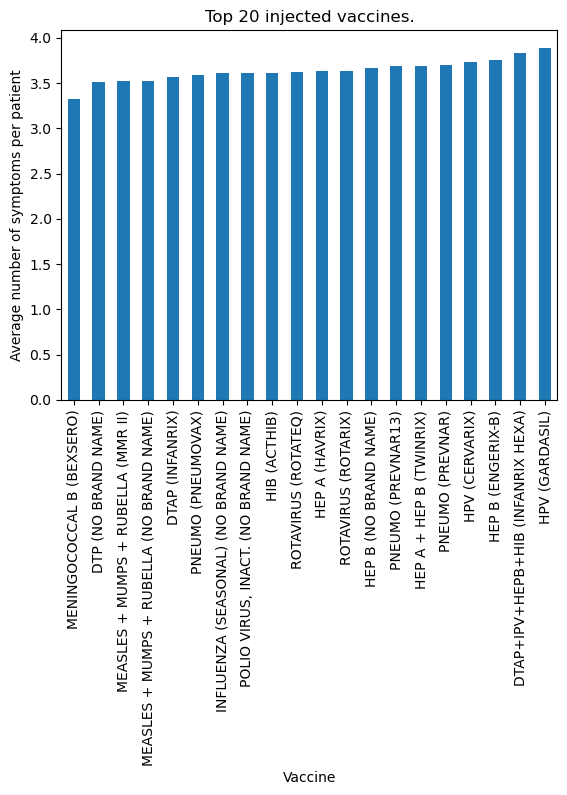

In [21]:
"""
Average number of symptoms for the top 20 injected vaccine.
"""
symptoms = spark.sql("""
    WITH TopVaccines AS (
        SELECT vax_name
        FROM OBSERVATIONS o
        JOIN VAX v ON v.vaers_id = o.vaers_id
        GROUP BY vax_name
        ORDER BY COUNT(*) DESC
        LIMIT 20
    ),
    VaccineSymptomCounts AS (
        SELECT v.vax_name, COUNT(DISTINCT o.symptom_id) AS symptom_count
        FROM OBSERVATIONS o
        JOIN VAX v ON o.vaers_id = v.vaers_id
        JOIN TopVaccines tv ON v.vax_name = tv.vax_name
        GROUP BY v.vax_name, o.observation_id
    )
    SELECT vax_name, AVG(symptom_count) AS avg_symptoms
    FROM VaccineSymptomCounts
    GROUP BY vax_name
    ORDER BY avg_symptoms;
""")
symptoms.show()
symptoms.toPandas().plot.bar(
    x='vax_name', 
    y='avg_symptoms', 
    title='Top 20 injected vaccines.', 
    legend=False, 
    xlabel='Vaccine', 
    ylabel='Average number of symptoms per patient'
)

### 3.2 MBA pour les observations de 2024 (15 points)

En utilisant les commandes du ``OBSERVATIONS_extract.csv``, créez un bloc de données où chaque ligne contient la liste des symptomes observés pour chaque patient, de manière similaire au GroceryDataset. Ensuite, exécutez l'algorithme MBA pour cet ensemble de transactions.
Le format devra permettre d'appeler l'ensemble des méthodes précédemment implémentées.

- Vous devez signaler le temps passé pour effectuer cette tâche.
- La sortie doit contenir le nom des symptômes.

In [22]:
%%time
transactions = spark.sql("""
    SELECT
        o.VAERS_ID,
        CONCAT_WS(',', COLLECT_LIST(DISTINCT s.SYMPTOM_NAME)) AS transaction
    FROM OBSERVATIONS o
    JOIN SYMPTOMS s ON o.SYMPTOM_ID = s.SYMPTOM_ID
    WHERE o.OBSERVATION_ID IS NOT NULL
    GROUP BY o.VAERS_ID
""")
transactions.show(truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------------------------+
|VAERS_ID|transaction                                                                                                                          |
+--------+-------------------------------------------------------------------------------------------------------------------------------------+
|25010   |Bronchitis                                                                                                                           |
|25540   |Chest pain,Rash maculo-papular,Paraesthesia,Laryngospasm,Conjunctivitis,Dyspnoea,Nausea,Asthma,Hyperventilation,Urticaria            |
|25651   |Abortion,Foetal disorder                                                                                                             |
|28414   |Haemolysis                                                                                                              

Attention, l'exécution de cellule-ci devrait prendre plusieurs dizaines de minutes, dépendamment de l'implémentation que vous avez codé.

In [23]:
%%time
transactions_rdd = transactions.rdd
patterns_rdd = transactions_rdd.flatMap(map_to_patterns)
reduced_patterns_rdd = patterns_rdd.reduceByKey(reduce_patterns)
subpatterns_rdd = reduced_patterns_rdd.flatMap(map_to_subpatterns)
final_patterns_rdd = subpatterns_rdd.mapValues(lambda v: [v] if not isinstance(v, list) else v).reduceByKey(reduce_patterns)
association_rules_rdd = final_patterns_rdd.map(map_to_assoc_rules)
filtered_rules_rdd = association_rules_rdd.filter(lambda x: len(x[1]) > 0)
filtered_rules_rdd.map(format_tuples).toDF(['patterns', 'association_rules']).sort('patterns').show(5, truncate=False)

+---------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4. MBA pour le dataset complet (20 points)


Comme vous l'avez probablement remarqué, même pour un ensemble de données moins volumineux, l'algorithme MBA est coûteux en calcul. Pour cette raison, cette fois, nous allons répéter le processus, mais en utilisant maintenant Google Cloud Platform (GCP) pour créer un grand cluster. Toutes les instructions pour créer un cluster avec spark et comment soumettre un travail seront expliquées dans le laboratoire. Dans tous les cas, vous devez lire les instructions données dans le ``Instruction_GCP.pdf``.

Cette fois, nous travaillerons avec le fichier ``OBSERVATIONS.csv``, qui contient plusieurs millions d'observations.

**PRODUCTION ATTENDUE**

Après avoir exécuté le MBA pour la plus grande collection d'observation, sélectionnez au hasard UN symptôme observé dans ``OBSERVATIONS`` et affichez les règles d'association (nom du symptôme et valeur d'association) de ce symptôme, c'est-à-dire lorsque le symptôme est seul. La sortie doit être formatée dans un tableau, où chaque ligne contenant les informations d'un symptôme associé.
Afin d'accélérer son exécution, vous pouvez créer un second notebook uniquement dédié à cette partie et l'insérer dans le rendu final.

- Affichez l'identifiant (SYMPTOM_ID) et le nom du symptôme (SYMPTOM_NAME) sélectionné au hasard.
- Signalez le temps d'exécution.

**Remarque importante : joignez des captures d'écran de votre sortie et de votre configuration de cluster.**

In [24]:
%%time

df_observations_full = spark.read.csv(ROOT + 'OBSERVATIONS.csv', header=True, sep=',', inferSchema=True)
df_observations_full.createOrReplaceTempView("OBSERVATIONS_FULL")

transactions_full = spark.sql("""
    SELECT
        o.vaers_id,
        CONCAT_WS(',', COLLECT_LIST(DISTINCT s.symptom_name)) AS transaction
    FROM OBSERVATIONS_FULL o
    JOIN SYMPTOMS s
        ON o.symptom_id = s.symptom_id
    WHERE o.observation_id IS NOT NULL
    GROUP BY o.vaers_id
""")
transactions_full.show(truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------------+
|vaers_id|transaction                                                                                                              |
+--------+-------------------------------------------------------------------------------------------------------------------------+
|25010   |Bronchitis                                                                                                               |
|25540   |Chest pain,Laryngospasm,Conjunctivitis,Rash maculo-papular,Nausea,Asthma,Dyspnoea,Paraesthesia,Urticaria,Hyperventilation|
|25651   |Abortion,Foetal disorder                                                                                                 |
|27308   |Urine analysis abnormal,Gaze palsy,Electroencephalogram abnormal,Convulsion                                              |
|27355   |Dysphagia,Salivary hypersecretion,Face oedema              

In [25]:
%%time
transaction_full_rdd = transactions_full.rdd
transaction_full_rdd = transaction_full_rdd.flatMap(map_to_patterns)
transaction_full_rdd = transaction_full_rdd.reduceByKey(reduce_patterns)
transaction_full_rdd = transaction_full_rdd.flatMap(map_to_subpatterns)
transaction_full_rdd = transaction_full_rdd.mapValues(lambda v: [v] if not isinstance(v, list) else v).reduceByKey(reduce_patterns)
transaction_full_rdd = transaction_full_rdd.map(map_to_assoc_rules)
transaction_full_rdd.map(format_tuples).toDF(['patterns', 'association_rules']).sort(['patterns']).show(50, truncate=False)

+---------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
%%time
from random import randint

sampled_transactions_df = (
    spark.sql("""
        SELECT 
            VAERS_ID, 
            CONCAT_WS(";", COLLECT_SET(SYMPTOM_NAME)) AS transaction
        FROM OBSERVATIONS_FULL o
        JOIN SYMPTOMS s ON o.SYMPTOM_ID = s.SYMPTOM_ID
        GROUP BY VAERS_ID
    """).sample(False, 0.001).limit(1).cache()          
)
sampled_transactions_df.show(1, truncate=False)

selected_transaction = sampled_transactions_df.collect()[0]['transaction']
print(f"Transaction: {selected_transaction}")

broadcast_symptoms = spark.sparkContext.broadcast(selected_transaction.split(";"))
filtered_association_rules = (transaction_full_rdd.filter(lambda x: len(x[0]) == 1 and x[0][0] in broadcast_symptoms.value).map(format_tuples).toDF(['patterns', 'association_rules']))
filtered_association_rules.show(50, truncate=False)

Sortie obtenue d'un résultat précédent : 

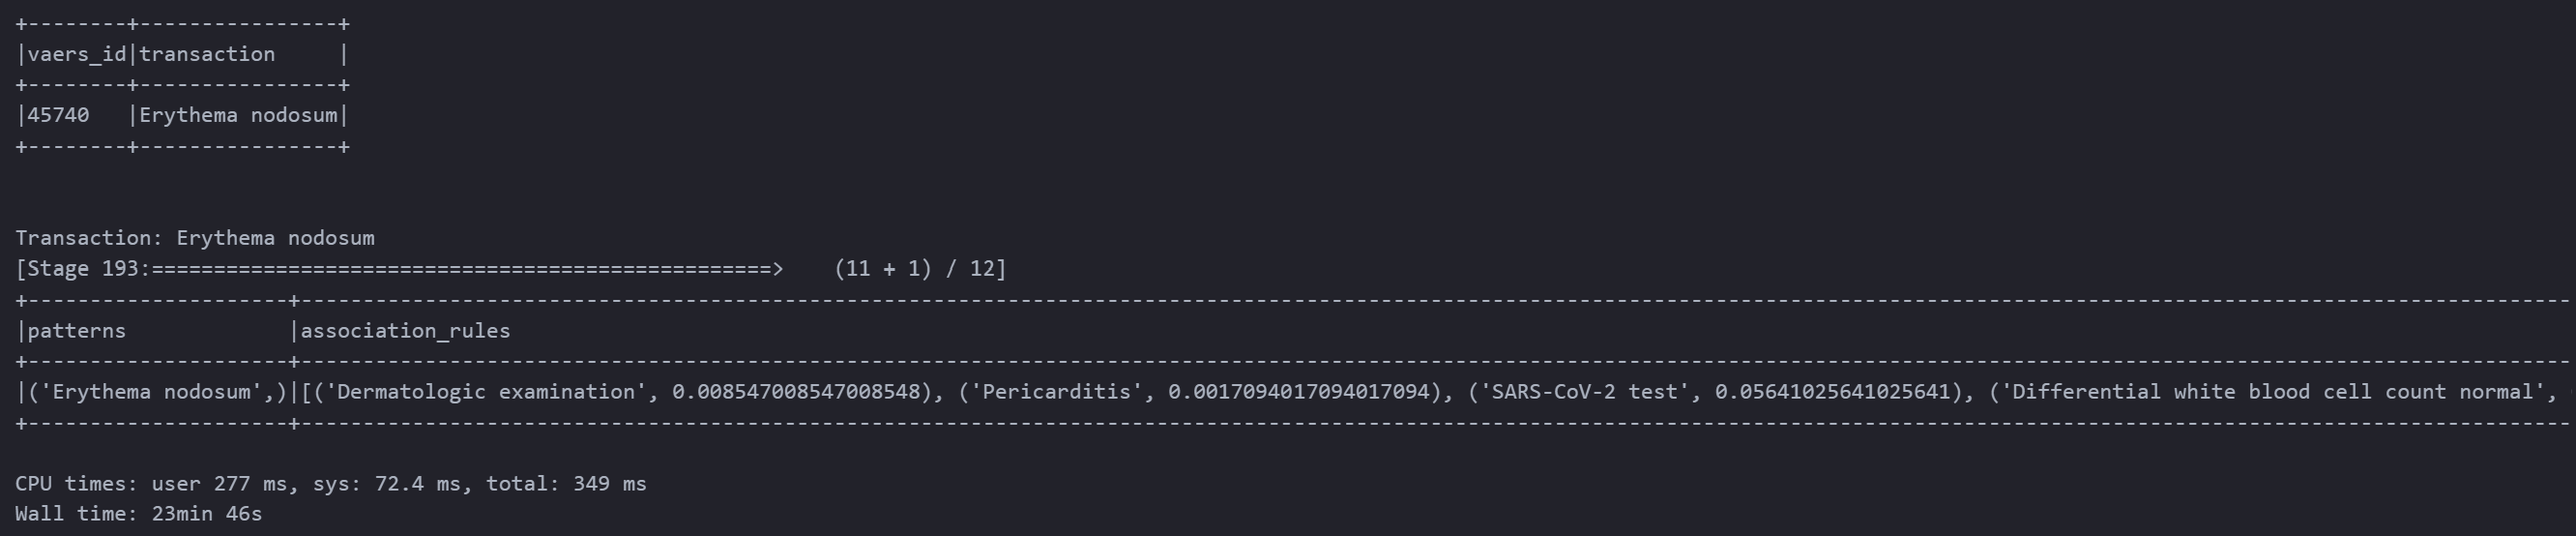

In [ ]:
+--------+----------------+
|vaers_id|transaction     |
+--------+----------------+
|45740   |Erythema nodosum|
+--------+----------------+

                                                                                
Transaction: Erythema nodosum
[Stage 193:==================================================>    (11 + 1) / 12]
+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patterns             |association_rules                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|('Erythema nodosum',)|[('Dermatologic examination', 0.008547008547008548), ('Pericarditis', 0.0017094017094017094), ('SARS-CoV-2 test', 0.05641025641025641), ('Differential white blood cell count normal', 0.0017094017094017094), ('Localised oedema', 0.0017094017094017094), ('Abnormal behaviour', 0.003418803418803419), ('Rheumatoid factor', 0.013675213675213675), ('Neoplasm', 0.0017094017094017094), ('Nasal congestion', 0.0017094017094017094), ('Monocyte count', 0.008547008547008548), ('Salmonella test positive', 0.0017094017094017094), ('Toxoplasma serology', 0.003418803418803419), ('Polyneuropathy', 0.0017094017094017094), ('Hyperacusis', 0.0017094017094017094), ('Thrombophlebitis superficial', 0.0017094017094017094), ('Mean cell haemoglobin concentration normal', 0.0017094017094017094), ('Vaccine positive rechallenge', 0.0017094017094017094), ('Urine ketone body', 0.0017094017094017094), ('Cardiac fibrillation', 0.0017094017094017094), ('Mean cell volume', 0.011965811965811967), ('Neuropathy', 0.003418803418803419), ('Hypertonia', 0.0017094017094017094), ('Haemoglobin decreased', 0.006837606837606838), ('Gastrointestinal examination', 0.0017094017094017094), ('Haematemesis', 0.0017094017094017094), ('Hepatic cyst', 0.0017094017094017094), ('Injection site erythema', 0.011965811965811967), ('Skin plaque', 0.003418803418803419), ('Lymphocyte percentage decreased', 0.0017094017094017094), ('Pneumonia', 0.0017094017094017094), ('Pregnancy test', 0.0017094017094017094), ('Antinuclear antibody negative', 0.008547008547008548), ('Feeling abnormal', 0.015384615384615385), ('Glucose urine', 0.003418803418803419), ('Mass', 0.008547008547008548), ('Computerised tomogram normal', 0.0017094017094017094), ('Platelet count normal', 0.005128205128205128), ('Ligament sprain', 0.0017094017094017094), ('Oral intake reduced', 0.0017094017094017094), ('Impaired work ability', 0.005128205128205128), ('Skin erosion', 0.0017094017094017094), ('Irritable bowel syndrome', 0.0017094017094017094), ('Skin lesion', 0.017094017094017096), ('Tachycardia', 0.008547008547008548), ('Electrophoresis abnormal', 0.0017094017094017094), ('Aspartate aminotransferase normal', 0.0017094017094017094), ('Angina bullosa haemorrhagica', 0.0017094017094017094), ('Torticollis', 0.0017094017094017094), ('Herpes simplex test', 0.0017094017094017094), ('Culture stool', 0.003418803418803419), ('Metabolic function test', 0.008547008547008548), ('Macule', 0.0017094017094017094), ('Viral infection', 0.005128205128205128), ('Chalazion', 0.0017094017094017094), ('Migraine without aura', 0.0017094017094017094), ('Blood gases', 0.0017094017094017094), ('Urinary retention', 0.0017094017094017094), ('Blood uric acid', 0.006837606837606838), ('Tonsillitis', 0.003418803418803419), ('C-reactive protein normal', 0.008547008547008548), ('Blood albumin decreased', 0.0017094017094017094), ('Vaccination site cellulitis', 0.0017094017094017094), ('Dry skin', 0.0017094017094017094), ('Rhinorrhoea', 0.005128205128205128), ('Immunisation reaction', 0.003418803418803419), ('Generalised oedema', 0.0017094017094017094), ('Vitiligo', 0.0017094017094017094), ('Colitis microscopic', 0.0017094017094017094), ('Mumps antibody test', 0.0017094017094017094), ('Tendon discomfort', 0.0017094017094017094), ('Epstein-Barr virus test positive', 0.0017094017094017094), ('Allergy to metals', 0.0017094017094017094), ('Decreased appetite', 0.017094017094017096), ('Eye swelling', 0.0017094017094017094), ('Haemangioma', 0.0017094017094017094), ('Parvovirus B19 infection', 0.0017094017094017094), ('Hepatitis viral test', 0.0017094017094017094), ('Hepatitis D antibody negative', 0.0017094017094017094), ('Coagulation test normal', 0.003418803418803419), ('Sensory disturbance', 0.0017094017094017094), ('Off label use', 0.011965811965811967), ('Eyelid rash', 0.0017094017094017094), ('Herpes virus infection', 0.0017094017094017094), ('Diplopia', 0.005128205128205128), ('Menstrual disorder', 0.0017094017094017094), ('Ecchymosis', 0.003418803418803419), ('Respiratory syncytial virus test positive', 0.0017094017094017094), ('Immunoglobulins increased', 0.005128205128205128), ('Hypoaesthesia', 0.010256410256410256), ('Abnormal loss of weight', 0.0017094017094017094), ('Angiotensin converting enzyme', 0.018803418803418803), ('Erysipelas', 0.006837606837606838), ('Pulmonary sarcoidosis', 0.005128205128205128), ('Oestradiol', 0.0017094017094017094), ('Anorexia', 0.0017094017094017094), ('Eosinophil count', 0.011965811965811967), ('Blood alkaline phosphatase normal', 0.0017094017094017094), ('Yersinia test', 0.005128205128205128), ('Treponema test', 0.005128205128205128), ('White blood cell count increased', 0.018803418803418803), ('Hepatic enzyme increased', 0.006837606837606838), ('Ultrasound abdomen', 0.005128205128205128), ('Blood pressure decreased', 0.003418803418803419), ('Circulatory collapse', 0.0017094017094017094), ('Blood immunoglobulin E', 0.005128205128205128), ('Blood iron decreased', 0.0017094017094017094), ('X-ray', 0.02735042735042735), ('Autoimmune thyroiditis', 0.0017094017094017094), ('Transferrin', 0.008547008547008548), ('DNA antibody', 0.003418803418803419), ('Fibrin D dimer', 0.015384615384615385), ('Bronchospasm', 0.0017094017094017094), ('Office visit', 0.0017094017094017094), ('White blood cell count normal', 0.003418803418803419), ('Mycobacterium tuberculosis complex test', 0.006837606837606838), ('Pain of skin', 0.008547008547008548), ('Human chorionic gonadotropin negative', 0.003418803418803419), ('Product use issue', 0.0017094017094017094), ('Product dose omission issue', 0.0017094017094017094), ('Fibrosis', 0.0017094017094017094), ('Ulcer', 0.003418803418803419), ('Hypokalaemia', 0.0017094017094017094), ('Epstein-Barr virus test negative', 0.0017094017094017094), ('Crying', 0.003418803418803419), ('Oedema peripheral', 0.05641025641025641), ('Nodular rash', 0.0017094017094017094), ('Infection', 0.008547008547008548), ('Tendon pain', 0.0017094017094017094), ('Conjunctivitis', 0.003418803418803419), ('Hepatitis viral test negative', 0.0017094017094017094), ('Beta 2 microglobulin', 0.003418803418803419), ('Bacterial infection', 0.0017094017094017094), ('Enzyme level test', 0.0017094017094017094), ('Pallor', 0.006837606837606838), ('Injection site inflammation', 0.0017094017094017094), ('Pharyngitis', 0.015384615384615385), ('Food allergy', 0.0017094017094017094), ('Tuberculin test', 0.005128205128205128), ('Rheumatoid factor positive', 0.0017094017094017094), ('Cyanosis', 0.003418803418803419), ('Body temperature', 0.035897435897435895), ('Urinary tract infection', 0.003418803418803419), ('X-ray normal', 0.003418803418803419), ('Photophobia', 0.003418803418803419), ('Magnetic resonance imaging', 0.011965811965811967), ('Monocyte count increased', 0.0017094017094017094), ('Autoimmune disorder', 0.003418803418803419), ('Asthma', 0.005128205128205128), ('Helicobacter pylori identification test positive', 0.0017094017094017094), ('Respiratory symptom', 0.0017094017094017094), ('Serology test', 0.008547008547008548), ('Mean cell haemoglobin', 0.006837606837606838), ('Diabetes mellitus', 0.0017094017094017094), ('Troponin I increased', 0.0017094017094017094), ('Granulocyte count', 0.0017094017094017094), ('Immune-mediated adverse reaction', 0.0017094017094017094), ('Throat irritation', 0.005128205128205128), ('Injection site nodule', 0.005128205128205128), ('Diarrhoea', 0.02735042735042735), ('Vaccination site swelling', 0.005128205128205128), ('General physical health deterioration', 0.008547008547008548), ('Lupus-like syndrome', 0.0017094017094017094), ('Drug hypersensitivity', 0.0017094017094017094), ('Pharyngolaryngeal pain', 0.003418803418803419), ("Raynaud's phenomenon", 0.0017094017094017094), ('Magnetic resonance imaging abdominal', 0.0017094017094017094), ('Fluid retention', 0.006837606837606838), ('Pharyngeal swelling', 0.0017094017094017094), ('Otoscopy normal', 0.0017094017094017094), ('Transferrin saturation', 0.008547008547008548), ('Blood pressure measurement', 0.010256410256410256), ('Auscultation', 0.006837606837606838), ('Pulmonary function test normal', 0.0017094017094017094), ('Palpitations', 0.006837606837606838), ('Deafness neurosensory', 0.0017094017094017094), ('Swelling', 0.03418803418803419), ('Visual analogue scale', 0.0017094017094017094), ('Flushing', 0.0017094017094017094), ('Glomerular filtration rate', 0.008547008547008548), ('Neuropathy peripheral', 0.0017094017094017094), ('Myocardial ischaemia', 0.0017094017094017094), ('Heart rate normal', 0.0017094017094017094), ('Creatinine urine', 0.003418803418803419), ('Depression', 0.0017094017094017094), ('Cutaneous vasculitis', 0.003418803418803419), ('Urinary sediment present', 0.0017094017094017094), ('Syncope', 0.003418803418803419), ('Weight', 0.0017094017094017094), ('Fistula', 0.0017094017094017094), ('Blood immunoglobulin M', 0.005128205128205128), ('Hyperleukocytosis', 0.003418803418803419), ('Abdomen scan', 0.003418803418803419), ('Alpha 2 globulin increased', 0.0017094017094017094), ('Serum sickness', 0.008547008547008548), ('Abasia', 0.0017094017094017094), ('Candida infection', 0.0017094017094017094), ('Hepatitis C antibody', 0.0017094017094017094), ('Total complement activity test', 0.0017094017094017094), ('Activities of daily living impaired', 0.0017094017094017094), ('Blood electrolytes', 0.006837606837606838), ('CSF test', 0.0017094017094017094), ('Chest X-ray', 0.04786324786324787), ('Menstruation delayed', 0.0017094017094017094), ('HIV test', 0.013675213675213675), ('Headache', 0.07179487179487179), ('Eye pain', 0.013675213675213675), ('Streptococcus test positive', 0.003418803418803419), ('Reticulocyte count', 0.0017094017094017094), ('Scleritis', 0.0017094017094017094), ('IIIrd nerve disorder', 0.0017094017094017094), ('Memory impairment', 0.003418803418803419), ('Blood urea normal', 0.0017094017094017094), ('Blood lactate dehydrogenase increased', 0.005128205128205128), ('Colonoscopy', 0.011965811965811967), ('Local reaction', 0.0017094017094017094), ('Hepatitis C', 0.0017094017094017094), ('Cutaneous sarcoidosis', 0.005128205128205128), ('Body temperature abnormal', 0.0017094017094017094), ('Incorrect route of drug administration', 0.0017094017094017094), ('Skin test positive', 0.0017094017094017094), ('Chromaturia', 0.0017094017094017094), ('Lymphocyte count decreased', 0.003418803418803419), ('Pain threshold decreased', 0.0017094017094017094), ('Pain in extremity', 0.08034188034188035), ('Blood bilirubin', 0.003418803418803419), ('Smear test', 0.0017094017094017094), ('Measles post vaccine', 0.0017094017094017094), ('Mycoplasma serology', 0.0017094017094017094), ('Eosinophil percentage increased', 0.0017094017094017094), ('Nodule on extremity', 0.003418803418803419), ('Immune thrombocytopenia', 0.0017094017094017094), ('Cough', 0.03076923076923077), ('Haemoglobin urine', 0.0017094017094017094), ('Arrhythmia', 0.0017094017094017094), ('Heart rate irregular', 0.0017094017094017094), ('Somnolence', 0.010256410256410256), ('Coagulation test', 0.0017094017094017094), ('Acute respiratory failure', 0.0017094017094017094), ('Mobility decreased', 0.011965811965811967), ('Full blood count abnormal', 0.003418803418803419), ('Hyperthyroidism', 0.0017094017094017094), ('Herpes virus test', 0.0017094017094017094), ('Pruritus', 0.044444444444444446), ('Vitamin B12', 0.008547008547008548), ('Pulmonary embolism', 0.003418803418803419), ('Polyarthritis', 0.008547008547008548), ('Dry eye', 0.0017094017094017094), ('Angiogram retina', 0.0017094017094017094), ('Deep vein thrombosis', 0.011965811965811967), ('Hepatosplenomegaly', 0.0017094017094017094), ('Exfoliative rash', 0.0017094017094017094), ('Arthropathy', 0.003418803418803419), ('Hypertransaminasaemia', 0.0017094017094017094), ('Iron binding capacity total decreased', 0.0017094017094017094), ('Blood lactate dehydrogenase', 0.020512820512820513), ('Pathology test', 0.003418803418803419), ('Night sweats', 0.015384615384615385), ('Injection site oedema', 0.003418803418803419), ('Interferon gamma release assay', 0.0017094017094017094), ('Paralysis flaccid', 0.0017094017094017094), ('Hepatitis B', 0.0017094017094017094), ('Angiotensin converting enzyme decreased', 0.0017094017094017094), ('Full blood count', 0.039316239316239315), ('Loss of personal independence in daily activities', 0.0017094017094017094), ('Haemoptysis', 0.0017094017094017094), ('Infectious mononucleosis', 0.006837606837606838), ('Muscular weakness', 0.010256410256410256), ('Cardiovascular examination', 0.0017094017094017094), ('Dermatitis exfoliative', 0.0017094017094017094), ('Red blood cell count', 0.010256410256410256), ('Tooth infection', 0.0017094017094017094), ('Streptococcal identification test negative', 0.003418803418803419), ('Electrophoresis protein', 0.011965811965811967), ('Sarcoidosis', 0.05128205128205128), ('Dehydration', 0.003418803418803419), ('Insomnia', 0.0017094017094017094), ('Nuclear magnetic resonance imaging normal', 0.0017094017094017094), ('Blood creatinine normal', 0.0017094017094017094), ('Histone antibody negative', 0.0017094017094017094), ('Vaccination site lymphadenopathy', 0.0017094017094017094), ('Urine leukocyte esterase', 0.0017094017094017094), ('Hypokinesia', 0.008547008547008548), ('Palmar erythema', 0.0017094017094017094), ('Glomerulonephritis', 0.0017094017094017094), ('Neutrophil percentage', 0.003418803418803419), ('Blood bicarbonate', 0.003418803418803419), ('C-reactive protein increased', 0.04957264957264957), ('Transaminases', 0.006837606837606838), ('Biopsy skin', 0.02564102564102564), ('Autoimmune myositis', 0.0017094017094017094), ('No reaction on previous exposure to drug', 0.0017094017094017094), ('Biopsy lymph gland', 0.0017094017094017094), ('Erythema', 0.09743589743589744), ('Thyroid function test normal', 0.0017094017094017094), ('Blood pressure increased', 0.006837606837606838), ('Fat necrosis', 0.0017094017094017094), ('Nodule', 0.046153846153846156), ('Rash macular', 0.006837606837606838), ('Blood sodium', 0.008547008547008548), ('Eye inflammation', 0.0017094017094017094), ('Activated partial thromboplastin time normal', 0.0017094017094017094), ('Parvovirus B19 test', 0.0017094017094017094), ('Injection site discolouration', 0.0017094017094017094), ('Dermatologic examination abnormal', 0.0017094017094017094), ('Fibrin D dimer increased', 0.005128205128205128), ('Pericardial effusion', 0.005128205128205128), ('Hepatitis B antibody negative', 0.0017094017094017094), ('Animal scratch', 0.0017094017094017094), ('Injection site pain', 0.017094017094017096), ('Leukocytosis', 0.010256410256410256), ('Gastroenteritis norovirus', 0.0017094017094017094), ('Full blood count normal', 0.022222222222222223), ('Vaccination site pain', 0.0017094017094017094), ('Systemic lupus erythematosus', 0.003418803418803419), ('Stillbirth', 0.0017094017094017094), ('Red cell distribution width', 0.005128205128205128), ('Vitamin B complex deficiency', 0.0017094017094017094), ('Pharyngitis streptococcal', 0.003418803418803419), ('Ultrasound kidney', 0.003418803418803419), ('Eczema', 0.0017094017094017094), ('Burning sensation', 0.0017094017094017094), ('Panniculitis', 0.015384615384615385), ('Epstein-Barr virus infection', 0.0017094017094017094), ('Haemoglobin normal', 0.003418803418803419), ('Vomiting', 0.023931623931623933), ('Lymphocyte morphology abnormal', 0.0017094017094017094), ('Tremor', 0.003418803418803419), ('Quality of life decreased', 0.0017094017094017094), ('X-ray limb', 0.0017094017094017094), ('Streptococcus test negative', 0.011965811965811967), ('Hepatitis C test negative', 0.0017094017094017094), ('Troponin', 0.003418803418803419), ('Blood parathyroid hormone', 0.005128205128205128), ('Antineutrophil cytoplasmic antibody negative', 0.0017094017094017094), ('Osteoarthritis', 0.010256410256410256), ('Epstein-Barr virus antibody positive', 0.005128205128205128), ('Incomplete course of vaccination', 0.0017094017094017094), ('Myalgia', 0.05128205128205128), ('Blood glucose normal', 0.0017094017094017094), ('Hepatocellular damage', 0.0017094017094017094), ('Inflammatory marker test', 0.003418803418803419), ('Pneumonitis', 0.0017094017094017094), ('Polymerase chain reaction', 0.008547008547008548), ('Endoscopy', 0.003418803418803419), ('Parotitis', 0.0017094017094017094), ('Arthritis enteropathic', 0.0017094017094017094), ('Beta globulin', 0.0017094017094017094), ('White blood cell count decreased', 0.006837606837606838), ('Coma scale normal', 0.0017094017094017094), ('Hepatitis B surface antigen', 0.0017094017094017094), ('Haemoglobin abnormal', 0.0017094017094017094), ('Dysgeusia', 0.0017094017094017094), ('Lymph node pain', 0.0017094017094017094), ('Ear pain', 0.0017094017094017094), ('Magnetic resonance imaging head', 0.003418803418803419), ('Phonophobia', 0.003418803418803419), ('Rheumatic disorder', 0.0017094017094017094), ('Hepatic enzyme abnormal', 0.0017094017094017094), ('Petechiae', 0.0017094017094017094), ('Endoscopy small intestine', 0.0017094017094017094), ('Platelet count increased', 0.005128205128205128), ('Injection site reaction', 0.013675213675213675), ('Blood creatine', 0.003418803418803419), ('Blood phosphorus', 0.006837606837606838), ('Rash erythematous', 0.017094017094017096), ('Constipation', 0.0017094017094017094), ('Haematocrit decreased', 0.005128205128205128), ('Liver injury', 0.0017094017094017094), ('Heart rate increased', 0.003418803418803419), ('HLA-B*27 assay', 0.0017094017094017094), ('Adverse event', 0.0017094017094017094), ('Morbillivirus test positive', 0.0017094017094017094), ('Malaria', 0.0017094017094017094), ('Blood aldosterone normal', 0.0017094017094017094), ('Blood magnesium', 0.0017094017094017094), ('Cellulitis', 0.02905982905982906), ('Back pain', 0.020512820512820513), ('Rheumatoid factor negative', 0.0017094017094017094), ('Odynophagia', 0.0017094017094017094), ('Alpha 1 globulin', 0.003418803418803419), ('Red blood cell sedimentation rate', 0.037606837606837605), ('Nasopharyngitis', 0.006837606837606838), ('Pigmentation disorder', 0.0017094017094017094), ('Haemoglobin', 0.015384615384615385), ('Differential white blood cell count', 0.003418803418803419), ('Bilirubin urine', 0.003418803418803419), ('Psoriasis', 0.003418803418803419), ('pH body fluid', 0.0017094017094017094), ('Chronic idiopathic pain syndrome', 0.0017094017094017094), ('Proctitis', 0.0017094017094017094), ('Computerised tomogram thorax abnormal', 0.003418803418803419), ('Blood testosterone', 0.0017094017094017094), ('Inner ear disorder', 0.0017094017094017094), ('Urine potassium', 0.0017094017094017094), ('Hot flush', 0.003418803418803419), ('Embolism venous', 0.0017094017094017094), ('Rash vesicular', 0.003418803418803419), ('Helicobacter test positive', 0.0017094017094017094), ('Blood immunoglobulin G', 0.006837606837606838), ('Renal failure', 0.0017094017094017094), ('Human chorionic gonadotropin', 0.0017094017094017094), ('Allodynia', 0.0017094017094017094), ('Hepatic lesion', 0.003418803418803419), ('Spinal myelogram', 0.0017094017094017094), ('Blood electrolytes normal', 0.0017094017094017094), ('Nerve conduction studies', 0.006837606837606838), ('Hilar lymphadenopathy', 0.005128205128205128), ('Blood fibrinogen', 0.006837606837606838), ('Iron binding capacity total', 0.006837606837606838), ('Hypergammaglobulinaemia', 0.0017094017094017094), ('Alpha 1 foetoprotein abnormal', 0.0017094017094017094), ('Endocrine test', 0.0017094017094017094), ('Proteinuria', 0.005128205128205128), ('Colitis', 0.005128205128205128), ('Joint warmth', 0.0017094017094017094), ('Liver function test abnormal', 0.006837606837606838), ('Dizziness', 0.023931623931623933), ('Rhinitis', 0.003418803418803419), ('Eosinophil percentage', 0.0017094017094017094), ('Alpha 2 globulin', 0.0017094017094017094), ('Skin necrosis', 0.003418803418803419), ('Hypotension', 0.0017094017094017094), ('Post inflammatory pigmentation change', 0.0017094017094017094), ('Feeling hot', 0.013675213675213675), ('Blood bilirubin unconjugated', 0.0017094017094017094), ('Lymphadenopathy', 0.04957264957264957), ('Urinary incontinence', 0.0017094017094017094), ('Peroneal nerve palsy', 0.003418803418803419), ('Joint stiffness', 0.003418803418803419), ('Laboratory test abnormal', 0.022222222222222223), ('Viral test negative', 0.0017094017094017094), ('Lymphopenia', 0.0017094017094017094), ('Type III immune complex mediated reaction', 0.003418803418803419), ('Streptococcus test', 0.03247863247863248), ('Cystitis', 0.0017094017094017094), ('Cardiovascular disorder', 0.003418803418803419), ('Vasodilatation', 0.0017094017094017094), ('Peripheral coldness', 0.0017094017094017094), ('Hepatitis C virus test', 0.003418803418803419), ('Body temperature increased', 0.011965811965811967), ('Monoclonal gammopathy', 0.0017094017094017094), ('Exercise tolerance decreased', 0.0017094017094017094), ('Cutaneous lupus erythematosus', 0.0017094017094017094), ('Immunoglobulins', 0.006837606837606838), ('Blood urea', 0.006837606837606838), ('Hepatitis C RNA', 0.0017094017094017094), ('Hepatitis B surface antigen negative', 0.0017094017094017094), ('Renal function test', 0.005128205128205128), ('Ultrasound abdomen normal', 0.003418803418803419), ('Difficulty in walking', 0.003418803418803419), ('Haematuria', 0.006837606837606838), ('Lymphatic system neoplasm', 0.0017094017094017094), ('Anaemia', 0.015384615384615385), ('Vena cava thrombosis', 0.0017094017094017094), ('Blood test abnormal', 0.005128205128205128), ('Histology abnormal', 0.0017094017094017094), ('Aspartate aminotransferase', 0.017094017094017096), ('Electrophoresis', 0.0017094017094017094), ('Skin warm', 0.017094017094017096), ('Angiogram', 0.003418803418803419), ('Lymphadenitis', 0.0017094017094017094), ('Inguinal mass', 0.003418803418803419), ('Taste disorder', 0.0017094017094017094), ("Still's disease", 0.003418803418803419), ('Immunisation', 0.010256410256410256), ('Antinuclear antibody', 0.02735042735042735), ('Bilirubin conjugated', 0.0017094017094017094), ('Chronic fatigue syndrome', 0.0017094017094017094), ('Induration', 0.006837606837606838), ('Visual disturbance', 0.0017094017094017094), ("Schirmer's test", 0.0017094017094017094), ('Epiglottitis', 0.0017094017094017094), ("Behcet's syndrome", 0.003418803418803419), ('Interstitial lung disease', 0.003418803418803419), ('Electroneurography', 0.0017094017094017094), ('Peripheral swelling', 0.05299145299145299), ('Blood urine present', 0.0017094017094017094), ('Haematocrit normal', 0.0017094017094017094), ('Influenza', 0.0017094017094017094), ('Seasonal allergy', 0.0017094017094017094), ('Gamma-glutamyltransferase', 0.013675213675213675), ('Haemostasis', 0.0017094017094017094), ('Optic neuritis', 0.0017094017094017094), ('Arteritis', 0.003418803418803419), ('HLA-B*27 positive', 0.0017094017094017094), ('Dermatitis exfoliative generalised', 0.0017094017094017094), ('Protein total', 0.010256410256410256), ('Computerised tomogram abnormal', 0.0017094017094017094), ('Skin reaction', 0.0017094017094017094), ('Alopecia', 0.0017094017094017094), ('Multi-organ disorder', 0.0017094017094017094), ('Hepatic function abnormal', 0.0017094017094017094), ('International normalised ratio', 0.0017094017094017094), ("Kawasaki's disease", 0.003418803418803419), ('Thrombocytosis', 0.005128205128205128), ('Activated partial thromboplastin time prolonged', 0.003418803418803419), ('Interleukin-2 receptor increased', 0.0017094017094017094), ('Dysphagia', 0.006837606837606838), ('Depressive symptom', 0.0017094017094017094), ('Electrocardiogram normal', 0.0017094017094017094), ('Faeces soft', 0.0017094017094017094), ('Papule', 0.005128205128205128), ('Body temperature fluctuation', 0.0017094017094017094), ('Glucose urine present', 0.0017094017094017094), ('Skin disorder', 0.006837606837606838), ('Dermatitis bullous', 0.003418803418803419), ('Agranulocytosis', 0.0017094017094017094), ('Proctoscopy', 0.0017094017094017094), ('Limb discomfort', 0.006837606837606838), ('Polyarteritis nodosa', 0.0017094017094017094), ('Intertrigo', 0.0017094017094017094), ('Rubella antibody positive', 0.0017094017094017094), ('Heart rate abnormal', 0.0017094017094017094), ('Chest discomfort', 0.003418803418803419), ('Hepatitis B antibody', 0.0017094017094017094), ('Gluten sensitivity', 0.0017094017094017094), ('Appendicitis', 0.0017094017094017094), ('Optical coherence tomography', 0.0017094017094017094), ('Blood lactic acid', 0.0017094017094017094), ('Urticaria', 0.03076923076923077), ('Jaundice neonatal', 0.0017094017094017094), ('Bladder pain', 0.0017094017094017094), ('Blood testosterone free', 0.0017094017094017094), ('Vitamin D', 0.010256410256410256), ('Immediate post-injection reaction', 0.0017094017094017094), ('Vertigo', 0.0017094017094017094), ('IL-2 receptor assay', 0.0017094017094017094), ('Visual field defect', 0.003418803418803419), ('Granulocyte count increased', 0.0017094017094017094), ('Culture stool positive', 0.0017094017094017094), ('Vaccination site erythema', 0.003418803418803419), ('Rash', 0.13333333333333333), ('Hypochromic anaemia', 0.0017094017094017094), ('Ultrasound scan normal', 0.006837606837606838), ('Viral titre', 0.003418803418803419), ('Polyuria', 0.003418803418803419), ('Blister', 0.008547008547008548), ('Prothrombin time', 0.005128205128205128), ('Abdominal pain', 0.02735042735042735), ('Positron emission tomogram', 0.010256410256410256), ('Bone pain', 0.003418803418803419), ('CSF test abnormal', 0.005128205128205128), ('Ear', 0.0017094017094017094), ('Hypersomnia', 0.003418803418803419), ('Procalcitonin', 0.003418803418803419), ('Neuralgia', 0.0017094017094017094), ('Borrelia test', 0.003418803418803419), ('Weight decreased', 0.018803418803418803), ('Oedema', 0.018803418803418803), ('Influenza virus test negative', 0.0017094017094017094), ('Colonoscopy abnormal', 0.005128205128205128), ('Gastrointestinal disorder', 0.003418803418803419), ('Protein urine', 0.010256410256410256), ('Antibody test negative', 0.003418803418803419), ('Psychomotor skills impaired', 0.0017094017094017094), ('Stool analysis', 0.008547008547008548), ('Macular degeneration', 0.0017094017094017094), ('Monocyte percentage', 0.003418803418803419), ('Neutrophil percentage increased', 0.003418803418803419), ('Biopsy skin normal', 0.003418803418803419), ('Oxygen saturation', 0.005128205128205128), ('Injection site rash', 0.005128205128205128), ('Antineutrophil cytoplasmic antibody', 0.015384615384615385), ('Eosinophil count decreased', 0.0017094017094017094), ('Urine analysis', 0.011965811965811967), ('Haemoglobin increased', 0.0017094017094017094), ('Feeding disorder', 0.0017094017094017094), ('Inflammatory marker increased', 0.0017094017094017094), ('Injection site pruritus', 0.0017094017094017094), ('Purpura', 0.003418803418803419), ('Glycosylated haemoglobin', 0.0017094017094017094), ('Oropharyngeal pain', 0.010256410256410256), ('Oral fibroma', 0.0017094017094017094), ('Swollen tongue', 0.003418803418803419), ('Blood culture negative', 0.0017094017094017094), ('Urinary sediment', 0.0017094017094017094), ('Intracranial pressure increased', 0.0017094017094017094), ('Mycobacterium tuberculosis complex test negative', 0.003418803418803419), ('Anaphylactic reaction', 0.003418803418803419), ('Urine electrolytes', 0.0017094017094017094), ('Single photon emission computerised tomogram', 0.0017094017094017094), ('Biopsy lymph gland normal', 0.0017094017094017094), ('Nephritis', 0.0017094017094017094), ('Lymphocyte percentage', 0.0017094017094017094), ('Urobilinogen urine', 0.003418803418803419), ('Gastrointestinal motility disorder', 0.0017094017094017094), ('Nitrite urine', 0.003418803418803419), ('Oral disorder', 0.0017094017094017094), ('Pyrexia', 0.18461538461538463), ('Spinal X-ray', 0.0017094017094017094), ('Disseminated intravascular coagulation', 0.0017094017094017094), ('COVID-19 immunisation', 0.003418803418803419), ('Erythema of eyelid', 0.0017094017094017094), ('Chest pain', 0.013675213675213675), ('Dermo-hypodermitis', 0.006837606837606838), ('Nausea', 0.02735042735042735), ('Irritability', 0.0017094017094017094), ('CSF cell count', 0.0017094017094017094), ('Computerised tomogram neck', 0.0017094017094017094), ('Amnesia', 0.0017094017094017094), ('Platelet count', 0.02735042735042735), ('Chest scan', 0.005128205128205128), ('Anal abscess', 0.0017094017094017094), ('Dyspnoea', 0.041025641025641026), ('Computerised tomogram liver abnormal', 0.0017094017094017094), ('Skin hyperpigmentation', 0.003418803418803419), ('Mycoplasma test positive', 0.0017094017094017094), ('Treponema test negative', 0.003418803418803419), ('Maternal exposure during pregnancy', 0.0017094017094017094), ('Hepatitis B test negative', 0.0017094017094017094), ('Contusion', 0.042735042735042736), ('Leukopenia', 0.0017094017094017094), ('Hypophagia', 0.0017094017094017094), ('Increased tendency to bruise', 0.0017094017094017094), ('Glasgow coma scale', 0.0017094017094017094), ('Musculoskeletal discomfort', 0.003418803418803419), ('Blood immunoglobulin E increased', 0.0017094017094017094), ('Haemorrhagic ovarian cyst', 0.0017094017094017094), ('Skin nodule', 0.008547008547008548), ('Postural orthostatic tachycardia syndrome', 0.0017094017094017094), ('Computerised tomogram', 0.023931623931623933), ('Transferrin saturation decreased', 0.0017094017094017094), ('Skin ulcer', 0.017094017094017096), ('Light chain analysis', 0.006837606837606838), ('Feeling cold', 0.0017094017094017094), ('Hyperaesthesia', 0.0017094017094017094), ('Urea urine', 0.003418803418803419), ('Post-traumatic stress disorder', 0.0017094017094017094), ('Condition aggravated', 0.02735042735042735), ('Blood potassium', 0.008547008547008548), ('Varicella zoster serology negative', 0.0017094017094017094), ('Presyncope', 0.003418803418803419), ('Glycosuria', 0.0017094017094017094), ('Blindness transient', 0.003418803418803419), ('Troponin I', 0.0017094017094017094), ('Mean cell volume decreased', 0.0017094017094017094), ('Hypocholesterolaemia', 0.0017094017094017094), ('HLA marker study', 0.003418803418803419), ('Hyperhomocysteinaemia', 0.0017094017094017094), ('Ultrasound Doppler', 0.010256410256410256), ('Renal impairment', 0.003418803418803419), ('Labile blood pressure', 0.0017094017094017094), ('Neutrophil count', 0.020512820512820513), ('Peritonsillitis', 0.0017094017094017094), ('External ear inflammation', 0.0017094017094017094), ('Fluorescence angiogram normal', 0.0017094017094017094), ('Heat oedema', 0.0017094017094017094), ('Hypothyroidism', 0.0017094017094017094), ('Computerised tomogram thorax', 0.011965811965811967), ('Joint noise', 0.0017094017094017094), ('Cross sensitivity reaction', 0.0017094017094017094), ('Interferon gamma level', 0.006837606837606838), ('Skin tightness', 0.0017094017094017094), ('Thyroxine free', 0.0017094017094017094), ('Bacterial test', 0.006837606837606838), ('Urine analysis normal', 0.003418803418803419), ('Illness', 0.003418803418803419), ('Cat scratch disease', 0.0017094017094017094), ('Arthritis', 0.044444444444444446), ('Ultrasound joint', 0.0017094017094017094), ('Abdominal lymphadenopathy', 0.0017094017094017094), ('Immunophenotyping', 0.003418803418803419), ('Interchange of vaccine products', 0.006837606837606838), ('Mean cell haemoglobin normal', 0.0017094017094017094), ('Subcutaneous nodule', 0.005128205128205128), ('Gait disturbance', 0.023931623931623933), ('Rhesus antibodies', 0.0017094017094017094), ('Antibody test', 0.003418803418803419), ('Aphthous ulcer', 0.008547008547008548), ('Blood glucose', 0.006837606837606838), ('Livedo reticularis', 0.0017094017094017094), ('Echocardiogram', 0.010256410256410256), ('Rash papular', 0.006837606837606838), ('Varicella virus test', 0.003418803418803419), ('Carbon dioxide increased', 0.0017094017094017094), ('Alanine aminotransferase', 0.017094017094017096), ('Serum ferritin', 0.011965811965811967), ('Eosinophil count increased', 0.0017094017094017094), ('Immunodeficiency', 0.0017094017094017094), ('Cryoglobulinaemia', 0.0017094017094017094), ('Terminal ileitis', 0.0017094017094017094), ('Liver function test', 0.010256410256410256), ('Peripheral vascular disorder', 0.005128205128205128), ('Visual acuity reduced', 0.0017094017094017094), ('Psoriatic arthropathy', 0.0017094017094017094), ('Incoherent', 0.0017094017094017094), ('Skin atrophy', 0.0017094017094017094), ('Hepatitis C antibody negative', 0.0017094017094017094), ('Loefgren syndrome', 0.008547008547008548), ('Adverse drug reaction', 0.0017094017094017094), ('Rheumatoid arthritis', 0.005128205128205128), ('Dysuria', 0.0017094017094017094), ('Injection site induration', 0.006837606837606838), ('Laboratory test normal', 0.010256410256410256), ('Weight bearing difficulty', 0.0017094017094017094), ('Axillary mass', 0.003418803418803419), ('Abnormal faeces', 0.0017094017094017094), ('Pseudo lymphoma', 0.0017094017094017094), ('Nuchal rigidity', 0.0017094017094017094), ('Asthenia', 0.046153846153846156), ('Dermatitis contact', 0.0017094017094017094), ('Acute febrile neutrophilic dermatosis', 0.006837606837606838), ('Respiratory viral panel', 0.0017094017094017094), ('Depressed mood', 0.0017094017094017094), ('HIV test negative', 0.006837606837606838), ('Neutrophil count increased', 0.003418803418803419), ('Laboratory test', 0.041025641025641026), ('Lipase', 0.005128205128205128), ('Epstein-Barr virus test', 0.015384615384615385), ('Episcleritis', 0.0017094017094017094), ('Granuloma', 0.003418803418803419), ('Streptococcal identification test positive', 0.0017094017094017094), ('Colitis ulcerative', 0.005128205128205128), ('Neutrophil count decreased', 0.003418803418803419), ('Superficial vein thrombosis', 0.0017094017094017094), ('Cardiovascular evaluation', 0.0017094017094017094), ('Thyroxine', 0.0017094017094017094), ('Biopsy small intestine', 0.0017094017094017094), ('Urine leukocyte esterase positive', 0.0017094017094017094), ('Herpes simplex serology negative', 0.0017094017094017094), ('Productive cough', 0.0017094017094017094), ('High density lipoprotein', 0.0017094017094017094), ('Antinuclear antibody positive', 0.003418803418803419), ('Endoscopy upper gastrointestinal tract', 0.0017094017094017094), ('Rash maculo-papular', 0.008547008547008548), ('Impaired quality of life', 0.0017094017094017094), ('Mouth ulceration', 0.003418803418803419), ('Urine protein/creatinine ratio', 0.0017094017094017094), ('Hypercalcaemia', 0.0017094017094017094), ('Blood triglycerides', 0.0017094017094017094), ('Angina pectoris', 0.003418803418803419), ("Crohn's disease", 0.015384615384615385), ('Rhinovirus infection', 0.0017094017094017094), ('Pregnancy test negative', 0.0017094017094017094), ('Hypoglycaemia', 0.0017094017094017094), ('Capillary fragility increased', 0.0017094017094017094), ('Complement factor C4', 0.005128205128205128), ('Haematochezia', 0.0017094017094017094), ('Biopsy kidney', 0.003418803418803419), ('Rectal examination', 0.0017094017094017094), ('Iridocyclitis', 0.003418803418803419), ('Culture throat negative', 0.0017094017094017094), ('Visual impairment', 0.003418803418803419), ('Orthopaedic examination', 0.0017094017094017094), (' nose and throat examination', 0.0017094017094017094), ('Gastric ulcer', 0.0017094017094017094), ('Chest X-ray abnormal', 0.005128205128205128), ('Rash pruritic', 0.010256410256410256), ('Cryoglobulins', 0.0017094017094017094), ('Pain in jaw', 0.0017094017094017094), ('Tissue infiltration', 0.0017094017094017094), ('COVID-19', 0.008547008547008548), ('Pulmonary mass', 0.0017094017094017094), ('Ocular hyperaemia', 0.003418803418803419), ('Mucosal inflammation', 0.0017094017094017094), ('Gamma-glutamyltransferase normal', 0.0017094017094017094), ('Hepatitis viral', 0.0017094017094017094), ('Sialoadenitis', 0.0017094017094017094), ('Acidosis', 0.0017094017094017094), ('Neck pain', 0.005128205128205128), ('Antiphospholipid antibodies', 0.0017094017094017094), ('Chlamydia test', 0.005128205128205128), ('Erythema multiforme', 0.011965811965811967), ('Arthritis reactive', 0.006837606837606838), ('General physical condition abnormal', 0.003418803418803419), ('C-reactive protein', 0.08205128205128205), ('Cardiolipin antibody', 0.003418803418803419), ('Magnetic resonance imaging abdominal abnormal', 0.0017094017094017094), ('Hemiparaesthesia', 0.0017094017094017094), ('Streptococcal infection', 0.0017094017094017094), ('Biopsy skin abnormal', 0.010256410256410256), ('Musculoskeletal pain', 0.0017094017094017094), ('Heart rate', 0.013675213675213675), ('Joint range of motion decreased', 0.003418803418803419), ('Ear swelling', 0.0017094017094017094), ('Angioedema', 0.0017094017094017094), ('Antinuclear antibody increased', 0.0017094017094017094), ('Exposure during pregnancy', 0.0017094017094017094), ('Investigation', 0.044444444444444446), ('Biopsy salivary gland', 0.0017094017094017094), ('Toothache', 0.0017094017094017094), ('Mononucleosis heterophile test positive', 0.0017094017094017094), ('Medial tibial stress syndrome', 0.0017094017094017094), ('Inflammation', 0.023931623931623933), ('Haematoma', 0.006837606837606838), ('Hypotony of eye', 0.0017094017094017094), ('Blood alkaline phosphatase increased', 0.0017094017094017094), ('Loss of consciousness', 0.005128205128205128), ('Extensive swelling of vaccinated limb', 0.0017094017094017094), ('Transaminases increased', 0.003418803418803419), ('Influenza like illness', 0.018803418803418803), ('Red blood cell sedimentation rate normal', 0.005128205128205128), ('Mean cell haemoglobin concentration', 0.005128205128205128), ('Low density lipoprotein', 0.0017094017094017094), ('Acute abdomen', 0.0017094017094017094), ('Dyspnoea exertional', 0.0017094017094017094), ('Biopsy', 0.041025641025641026), ('Hypotonia', 0.005128205128205128), ('Weight increased', 0.0017094017094017094), ('Skin mass', 0.010256410256410256), ('Angioneurotic oedema', 0.006837606837606838), ('Coronavirus test', 0.0017094017094017094), ('Retroperitoneal lymphadenopathy', 0.0017094017094017094), ('Mean cell volume normal', 0.0017094017094017094), ('Vaccination complication', 0.006837606837606838), ('Metabolic function test normal', 0.006837606837606838), ('Central venous catheterisation', 0.0017094017094017094), ('Blood test', 0.08034188034188035), ('Blood creatine phosphokinase increased', 0.0017094017094017094), ('Disease recurrence', 0.003418803418803419), ('Tumour marker test', 0.0017094017094017094), ('Blood thyroid stimulating hormone normal', 0.003418803418803419), ('Syphilis', 0.0017094017094017094), ('Blood lactate dehydrogenase normal', 0.0017094017094017094), ('Hyperpyrexia', 0.0017094017094017094), ('Iritis', 0.003418803418803419), ('Lymphocyte count', 0.013675213675213675), ('Cerebrovascular accident', 0.0017094017094017094), ('Blood creatinine', 0.017094017094017096), ('Rheumatological examination', 0.005128205128205128), ('Atrial fibrillation', 0.0017094017094017094), ('Hyponatraemia', 0.0017094017094017094), ('Spirometry', 0.0017094017094017094), ('Neurological examination', 0.003418803418803419), ('Scan', 0.003418803418803419), ('Tuberculin test negative', 0.003418803418803419), ('Hyperhidrosis', 0.008547008547008548), ('Injection site swelling', 0.008547008547008548), ('Bronchitis', 0.0017094017094017094), ('Large intestine infection', 0.0017094017094017094), ('Hyperthermia', 0.0017094017094017094), ('Basophil count', 0.006837606837606838), ('Computerised tomogram pelvis abnormal', 0.0017094017094017094), ('Apathy', 0.0017094017094017094), ('Vision blurred', 0.003418803418803419), ('Complement factor', 0.0017094017094017094), ('Upper respiratory tract infection', 0.0017094017094017094), ('Sweat gland tumour', 0.0017094017094017094), ('Enterovirus test', 0.003418803418803419), ('Nephropathy', 0.0017094017094017094), ('Joint effusion', 0.0017094017094017094), ('Seizure', 0.0017094017094017094), ('Microbiology test', 0.0017094017094017094), ('Cytomegalovirus test', 0.011965811965811967), ('Hepatitis B virus test', 0.006837606837606838), ('Primary biliary cholangitis', 0.0017094017094017094), ('Blood immunoglobulin A', 0.003418803418803419), ('Anti-thyroid antibody', 0.0017094017094017094), ('Blood folate', 0.006837606837606838), ('X-ray gastrointestinal tract normal', 0.0017094017094017094), ('Thyroid hormones test', 0.0017094017094017094), ('Alpha-1 anti-trypsin', 0.0017094017094017094), ('Streptococcal identification test', 0.005128205128205128), ('Hepatitis B core antigen', 0.0017094017094017094), ('Faecal calprotectin', 0.0017094017094017094), ('Post-acute COVID-19 syndrome', 0.0017094017094017094), ('Activated partial thromboplastin time', 0.003418803418803419), ('Wrong product administered', 0.005128205128205128), ('Abscess', 0.005128205128205128), ('Complement factor C3', 0.006837606837606838), ('Chills', 0.03247863247863248), ('Epstein-Barr virus antibody negative', 0.006837606837606838), ('Body mass index', 0.005128205128205128), ('Blood ketone body', 0.0017094017094017094), ('Eye disorder', 0.0017094017094017094), ('Blood calcium', 0.011965811965811967), ('Limb mass', 0.013675213675213675), ('Gait inability', 0.006837606837606838), ('Type IV hypersensitivity reaction', 0.0017094017094017094), ('Immunology test', 0.006837606837606838), ('Pain assessment', 0.0017094017094017094), ('Listless', 0.0017094017094017094), ('Platelet count decreased', 0.003418803418803419), ('Eyelid oedema', 0.005128205128205128), ('Vaginal haemorrhage', 0.0017094017094017094), ('Blood alkaline phosphatase', 0.008547008547008548), ('Abdominal pain upper', 0.011965811965811967), ('Sports injury', 0.0017094017094017094), ('Mycoplasma test', 0.003418803418803419), ('Tendon rupture', 0.0017094017094017094), ('Chronic gastritis', 0.0017094017094017094), ('Lethargy', 0.005128205128205128), ('Inappropriate schedule of drug administration', 0.0017094017094017094), ('Lacrimation increased', 0.0017094017094017094), ('Vasculitis', 0.022222222222222223), ('Stomatitis', 0.0017094017094017094), ('Atelectasis', 0.0017094017094017094), ('Pulmonary physical examination', 0.0017094017094017094), ('Brain natriuretic peptide', 0.005128205128205128), ('Culture throat', 0.0017094017094017094), ('Joint swelling', 0.046153846153846156), ('Blood culture', 0.005128205128205128), ('Tuberculosis', 0.0017094017094017094), ('Psychomotor hyperactivity', 0.0017094017094017094), ('Urine analysis abnormal', 0.003418803418803419), ('Musculoskeletal stiffness', 0.006837606837606838), ('Blood thyroid stimulating hormone', 0.020512820512820513), ('Prothrombin level', 0.003418803418803419), ('Drug ineffective', 0.003418803418803419), ('Lymphadenopathy mediastinal', 0.003418803418803419), ('Viral test', 0.008547008547008548), ('Keratitis', 0.0017094017094017094), ('Blood urine', 0.0017094017094017094), ('Hypertension', 0.005128205128205128), ('Anti-transglutaminase antibody', 0.0017094017094017094), ('Cardiac disorder', 0.0017094017094017094), ('Discomfort', 0.0017094017094017094), ('Injection site hypersensitivity', 0.006837606837606838), ('Noninfective gingivitis', 0.0017094017094017094), ('Urine sodium', 0.0017094017094017094), ('Muscle atrophy', 0.0017094017094017094), ('Dysstasia', 0.006837606837606838), ('Thyroid function test', 0.0017094017094017094), ('Ophthalmological examination', 0.003418803418803419), ('Skin test', 0.005128205128205128), ('Similar reaction on previous exposure to drug', 0.0017094017094017094), ('Erythema induratum', 0.005128205128205128), ('Inappropriate schedule of product administration', 0.017094017094017096), ('Culture throat positive', 0.0017094017094017094), ('Blood albumin', 0.006837606837606838), ('Papilloedema', 0.0017094017094017094), ('Borrelia test negative', 0.0017094017094017094), ('Complement factor normal', 0.003418803418803419), ('Ultrasound scan', 0.020512820512820513), ('Salivary scan', 0.0017094017094017094), ('Blood pressure', 0.0017094017094017094), ('Strabismus', 0.0017094017094017094), ('Myocarditis', 0.0017094017094017094), ('Bone scan normal', 0.0017094017094017094), ('Neurological examination normal', 0.0017094017094017094), ('Lumbar puncture abnormal', 0.0017094017094017094), ('Histology', 0.011965811965811967), ('White blood cell count', 0.037606837606837605), ('Computerised tomogram abdomen', 0.0017094017094017094), ('Enterocolitis haemorrhagic', 0.0017094017094017094), ('Organising pneumonia', 0.0017094017094017094), ('HIV antibody negative', 0.0017094017094017094), ('Haematocrit', 0.006837606837606838), ('Polycystic ovaries', 0.0017094017094017094), ('Red blood cell count decreased', 0.003418803418803419), ('Blood test normal', 0.005128205128205128), ('Blood cholesterol', 0.0017094017094017094), ('X-ray of pelvis and hip', 0.0017094017094017094), ('Nervous system disorder', 0.0017094017094017094), ('Phlebitis', 0.003418803418803419), ('Immune system disorder', 0.0017094017094017094), ('Tongue geographic', 0.0017094017094017094), ('SARS-CoV-2 antibody test', 0.003418803418803419), ('Thyroiditis', 0.0017094017094017094), ('Malaise', 0.037606837606837605), ('Diagnostic procedure', 0.0017094017094017094), ('SARS-CoV-2 test negative', 0.006837606837606838), ('Liver function test normal', 0.005128205128205128), ('Injection site warmth', 0.005128205128205128), ('Amino acid level', 0.0017094017094017094), ('Abdominal mass', 0.0017094017094017094), ('Synovitis', 0.0017094017094017094), ('Breath sounds', 0.0017094017094017094), ('Physical examination', 0.013675213675213675), ('Paraesthesia', 0.010256410256410256), ('Phlebitis superficial', 0.0017094017094017094), ('Pingueculitis', 0.0017094017094017094), ('Enterovirus infection', 0.0017094017094017094), ('Red blood cell sedimentation rate increased', 0.0547008547008547), ('Pustule', 0.0017094017094017094), ('Disturbance in attention', 0.006837606837606838), ('Dermatitis', 0.0017094017094017094), ('Injection site mass', 0.005128205128205128), ('Arthralgia', 0.17264957264957265), ('Ehrlichia test', 0.0017094017094017094), ('Sleep disorder', 0.005128205128205128), ('Specialist consultation', 0.013675213675213675), ('Haematology test normal', 0.0017094017094017094), ('Tenosynovitis', 0.005128205128205128), ('Blood iron', 0.010256410256410256), ('Chest X-ray normal', 0.005128205128205128), ('Uveitis', 0.011965811965811967), ('Tendon disorder', 0.0017094017094017094), ('C-reactive protein abnormal', 0.0017094017094017094), ('Septal panniculitis', 0.003418803418803419), ('Hypersensitivity', 0.015384615384615385), ('White blood cells urine positive', 0.0017094017094017094), ('Skin discolouration', 0.015384615384615385), ('Fatigue', 0.05982905982905983), ('Liver function test increased', 0.005128205128205128), ('Pain', 0.09401709401709402), ('Skin exfoliation', 0.0017094017094017094), ('Helicobacter test', 0.003418803418803419), ('Eye discharge', 0.0017094017094017094), ('Anxiety', 0.003418803418803419), ('Reticulocyte percentage', 0.0017094017094017094), ('Electrocardiogram', 0.018803418803418803), ('Tenderness', 0.02735042735042735), ('Urological examination normal', 0.0017094017094017094), ('Post viral fatigue syndrome', 0.0017094017094017094), ('Mean platelet volume', 0.003418803418803419), ('SARS-CoV-2 test positive', 0.0017094017094017094), ('Mean cell haemoglobin decreased', 0.0017094017094017094), ('Ultrasound Doppler normal', 0.0017094017094017094), ('Biopsy vagina', 0.0017094017094017094), ('Swelling face', 0.006837606837606838), ('Performance status decreased', 0.0017094017094017094), ('Movement disorder', 0.0017094017094017094), ('Lung disorder', 0.003418803418803419), ('Amylase', 0.0017094017094017094), ('Blood creatine phosphokinase', 0.008547008547008548), ('Cytomegalovirus test negative', 0.005128205128205128), ('Ataxia', 0.0017094017094017094), ('Alanine aminotransferase normal', 0.0017094017094017094), ('Methaemoglobinaemia', 0.0017094017094017094), ('Lip swelling', 0.005128205128205128)]|
+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

CPU times: user 277 ms, sys: 72.4 ms, total: 349 ms
Wall time: 23min 46s

Configuration Cluster :

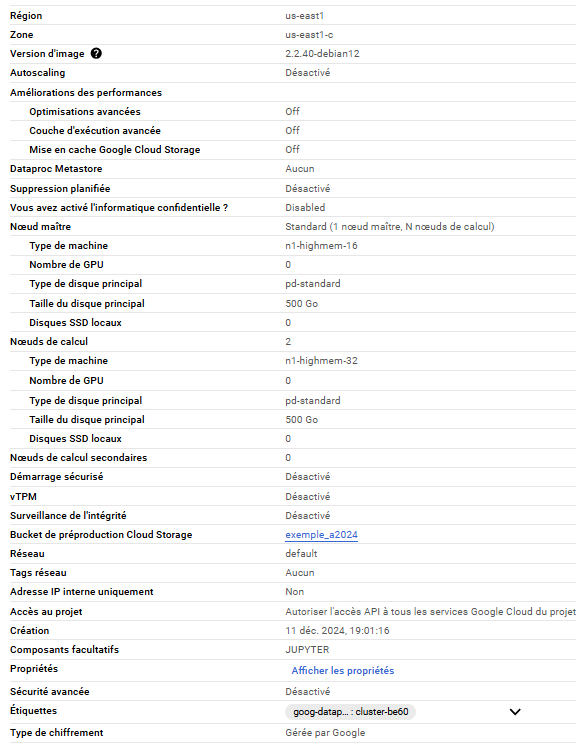